In [1]:
%reload_ext autoreload
%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 10 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


revision_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  6e9a5e67b18041859a70e093d39f61f5   
18ca3b4ea18f4963ba66d54d209c8df6  526a5b11fcec43c1acae71fc85f6e048   
18ca4a7bbd7a46369bcf6a37b888b6aa  4aa1e97ce2ea4e46a0717333a21b33c9   
18ca6a50c0704715aa48e935f74f2499  aaa3597dc1424b588907ec9aaa79fc4e   
18ca78d943ac434eb03394195d567362  2aa8f762dbb148478358d697be2899de   

                                                   organization_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  b687311ab9944ff4aa57f73ef9c8dd11   
18ca3b4ea18f4963ba66d54d209c8df6  c41660388a04449a995dccf97d894f46   
18ca4a7bbd7a46369bcf6a37b888b6aa  354d0de44863452487e0d586085db660   
18ca6a50c0704715aa48e935f74f2499  d31d0bd9bd92417bbc643f50959d0eb8   
18ca78d943ac434eb03394195d567362  8758cea71ad74736883f3649b47a0957   

                                             datetime description  \
model_id                                                            
18ca3235ecba415da2e24298878ca872  2019-09-03 00:49:15         NaN   
18ca3b4ea18f4963ba66d54d209c8df6  2019-06-12 02:19:30         NaN   
18ca4a7bbd7a46369bcf6a37b888b6aa  2019-09-12 20:30:39         NaN   
18ca6a50c0704715aa48e935f74f2499  2018-05-31 12:15:08         NaN   
18ca78d943ac434eb03394195d567362  2021-09-13 09:02:40         NaN   

                                                                            name  \
model_id                                                                           
18ca3235ecba415da2e24298878ca872                                      Guidelines   
18ca3b4ea18f4963ba66d54d209c8df6                                   12345678_rev1   
18ca4a7bbd7a46369bcf6a37b888b6aa                                   Procure parts   
18ca6a50c0704715aa48e935f74f2499                                   Aufgabe 5.3.2   
18ca78d943ac434eb03394195d567362  Ebene 2 - Prozessbereich: Auftragsdurchführung   

                                 type  \
model_id                                
18ca3235ecba415da2e24298878ca872  NaN   
18ca3b4ea18f4963ba66d54d209c8df6  NaN   
18ca4a7bbd7a46369bcf6a37b888b6aa  NaN   
18ca6a50c0704715aa48e935f74f2499  NaN   
18ca78d943ac434eb03394195d567362  NaN   

                                                                        namespace  
model_id                                                                           
18ca3235ecba415da2e24298878ca872              http://b3mn.org/stencilset/bpmn2.0#  
18ca3b4ea18f4963ba66d54d209c8df6              http://b3mn.org/stencilset/bpmn2.0#  
18ca4a7bbd7a46369bcf6a37b888b6aa              http://b3mn.org/stencilset/bpmn2.0#  
18ca6a50c0704715aa48e935f74f2499  http://www.signavio.com/stencilsets/processmap#  
18ca78d943ac434eb03394195d567362  http://www.signavio.com/stencilsets/processmap#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

42291

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.46234325633260814

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

49180

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5376567436673918

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

49180

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

Notation  Frequency
0                         BPMN 2.0      36123
1                              EPC       2853
2                      Value Chain       2098
3                         BPMN 1.1       1431
4                    UML 2.2 Class       1349
5                          DMN 1.0       1084
6                    ArchiMate 2.1       1009
7                        Petri Net        989
8                     UML Use Case        923
9                       Organigram        396
10           BPMN 2.0 Choreography        381
11           BPMN 2.0 Conversation        239
12               FMC Block Diagram        117
13                        CMMN 1.0         77
14                             CPN         41
15                     Journey Map         30
16                        YAWL 2.2         24
17  Process Documentation Template          9
18                          jBPM 4          7

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
if df_notations['Notation'].nunique() > 3:
    df_notations = DataFilter(df_notations)
    df_notations = df_notations.filter_data("namespaces", "max", 5)
df_notations

Notation  Frequency
0                         BPMN 2.0      36123
1                              EPC       2853
2                      Value Chain       2098
3                         BPMN 1.1       1431
4                    UML 2.2 Class       1349
5                          DMN 1.0       1084
6                    ArchiMate 2.1       1009
7                        Petri Net        989
8                     UML Use Case        923
9                       Organigram        396
10           BPMN 2.0 Choreography        381
11           BPMN 2.0 Conversation        239
12               FMC Block Diagram        117
13                        CMMN 1.0         77
14                             CPN         41
15                     Journey Map         30
16                        YAWL 2.2         24
17  Process Documentation Template          9
18                          jBPM 4          7

We can visualise the number of models in different modeling notations.

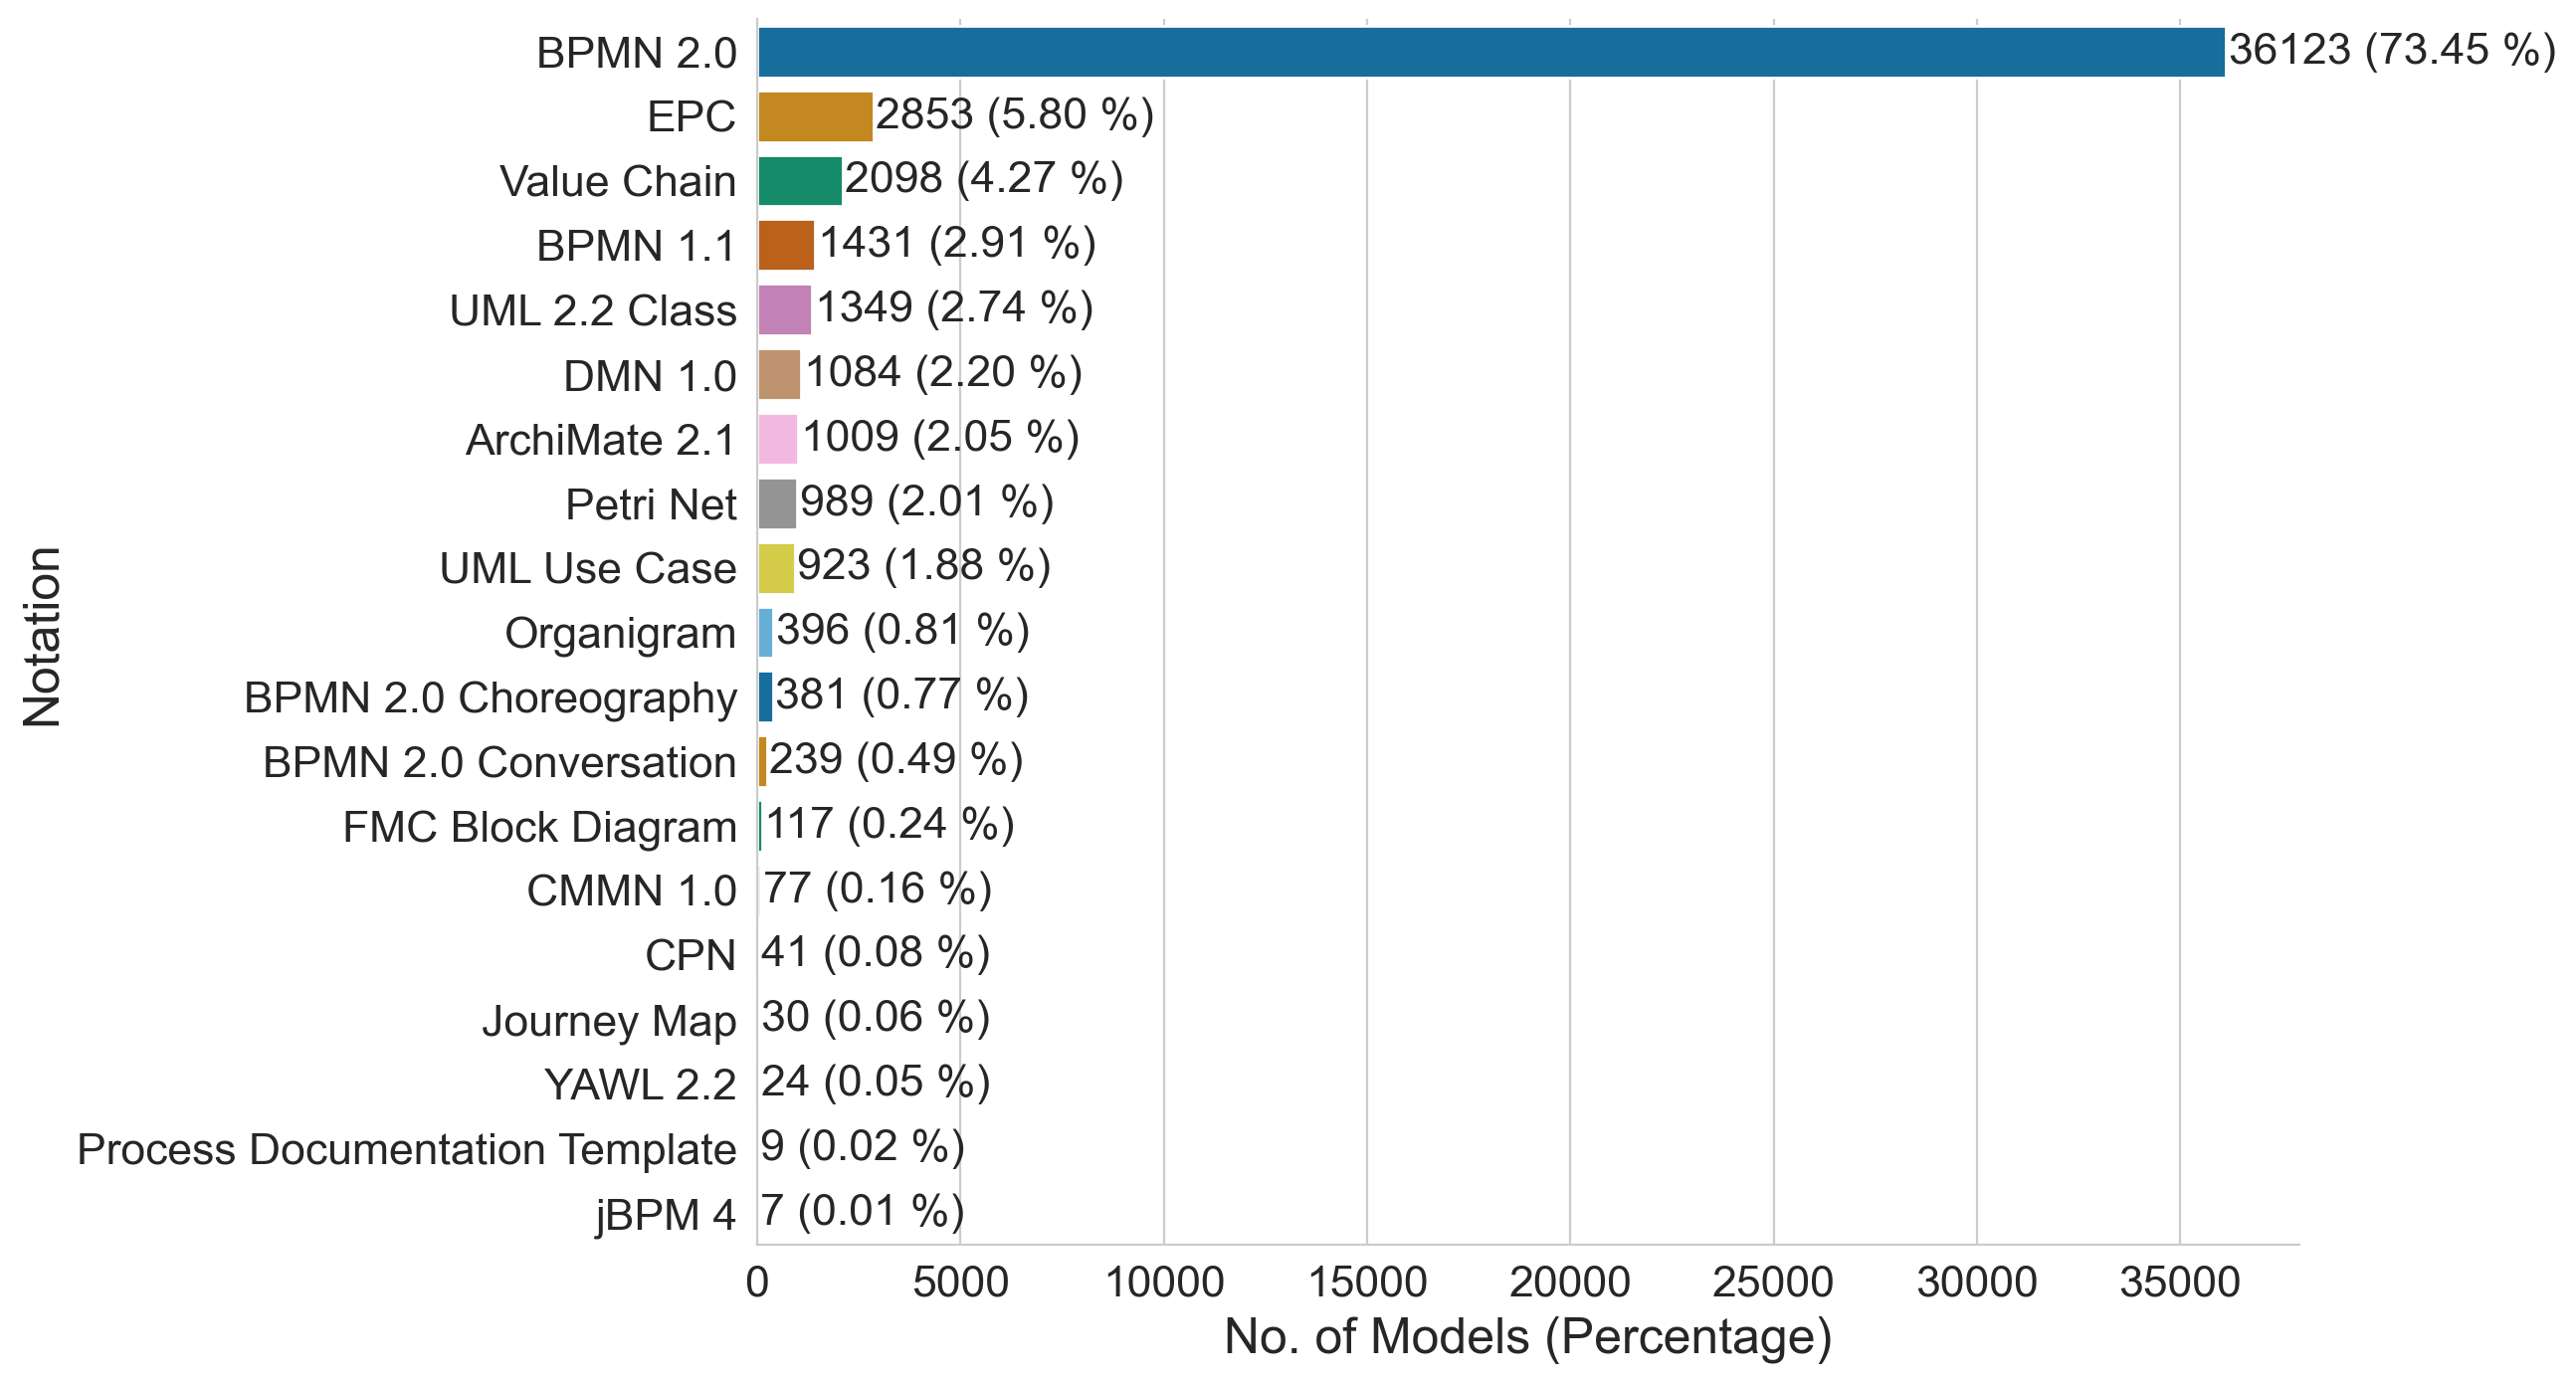

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
containers_nb = df_notations['Notation'].nunique()
ax=sns.barplot(x="Frequency",y="Notation",hue="Notation",data=df_notations,estimator = np.max, errorbar=('ci', 0),palette = sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
labels = [f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
sns.despine()
#ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  43fe80a91c114d3ca121e8e8fb03a0a6   

                                                   organization_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
c1f9781d06594f068bee14f96d6744f3 2011-12-01 23:11:10         NaN   

                                              name       type  \
model_id                                                        
c1f9781d06594f068bee14f96d6744f3  Ampel - Lösung 1  Petrinets   

                                                             namespace  
model_id                                                                
c1f9781d06594f068bee14f96d6744f3  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
90890b4f53b5429ba5385ad93b860301  86144360fbff44eaafc9d513542d10a2   

                                                   organization_id  \
model_id                                                             
90890b4f53b5429ba5385ad93b860301  8f45cdba3d7c4c1b814f1ab1a883e289   

                                            datetime description  \
model_id                                                           
90890b4f53b5429ba5385ad93b860301 2021-09-22 03:15:41         NaN   

                                                     name type  \
model_id                                                         
90890b4f53b5429ba5385ad93b860301  Preparar música en vivo  NaN   

                                                            namespace  
model_id                                                               
90890b4f53b5429ba5385ad93b860301  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#      36123
1                  http://b3mn.org/stencilset/epc#       2853
2  http://www.signavio.com/stencilsets/processmap#       2098
3              http://b3mn.org/stencilset/bpmn1.1#       1431
4          http://b3mn.org/stencilset/UML2.2Class#       1349

In [22]:
# handling the case where we have unknown namespaces in the dataset
# to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum(numeric_only=True,min_count=1)
df_meta_selected = df_meta_selected['Count'].fillna(0)
df_meta_selected = df_meta_selected.reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class     14  2015
1  UML 2.2 Class    108  2016
2  UML 2.2 Class    165  2017
3  UML 2.2 Class    153  2018
4  UML 2.2 Class     95  2019

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

2

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class     14  2015
1  UML 2.2 Class    108  2016
2  UML 2.2 Class    165  2017
3  UML 2.2 Class    153  2018
4  UML 2.2 Class     95  2019

In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

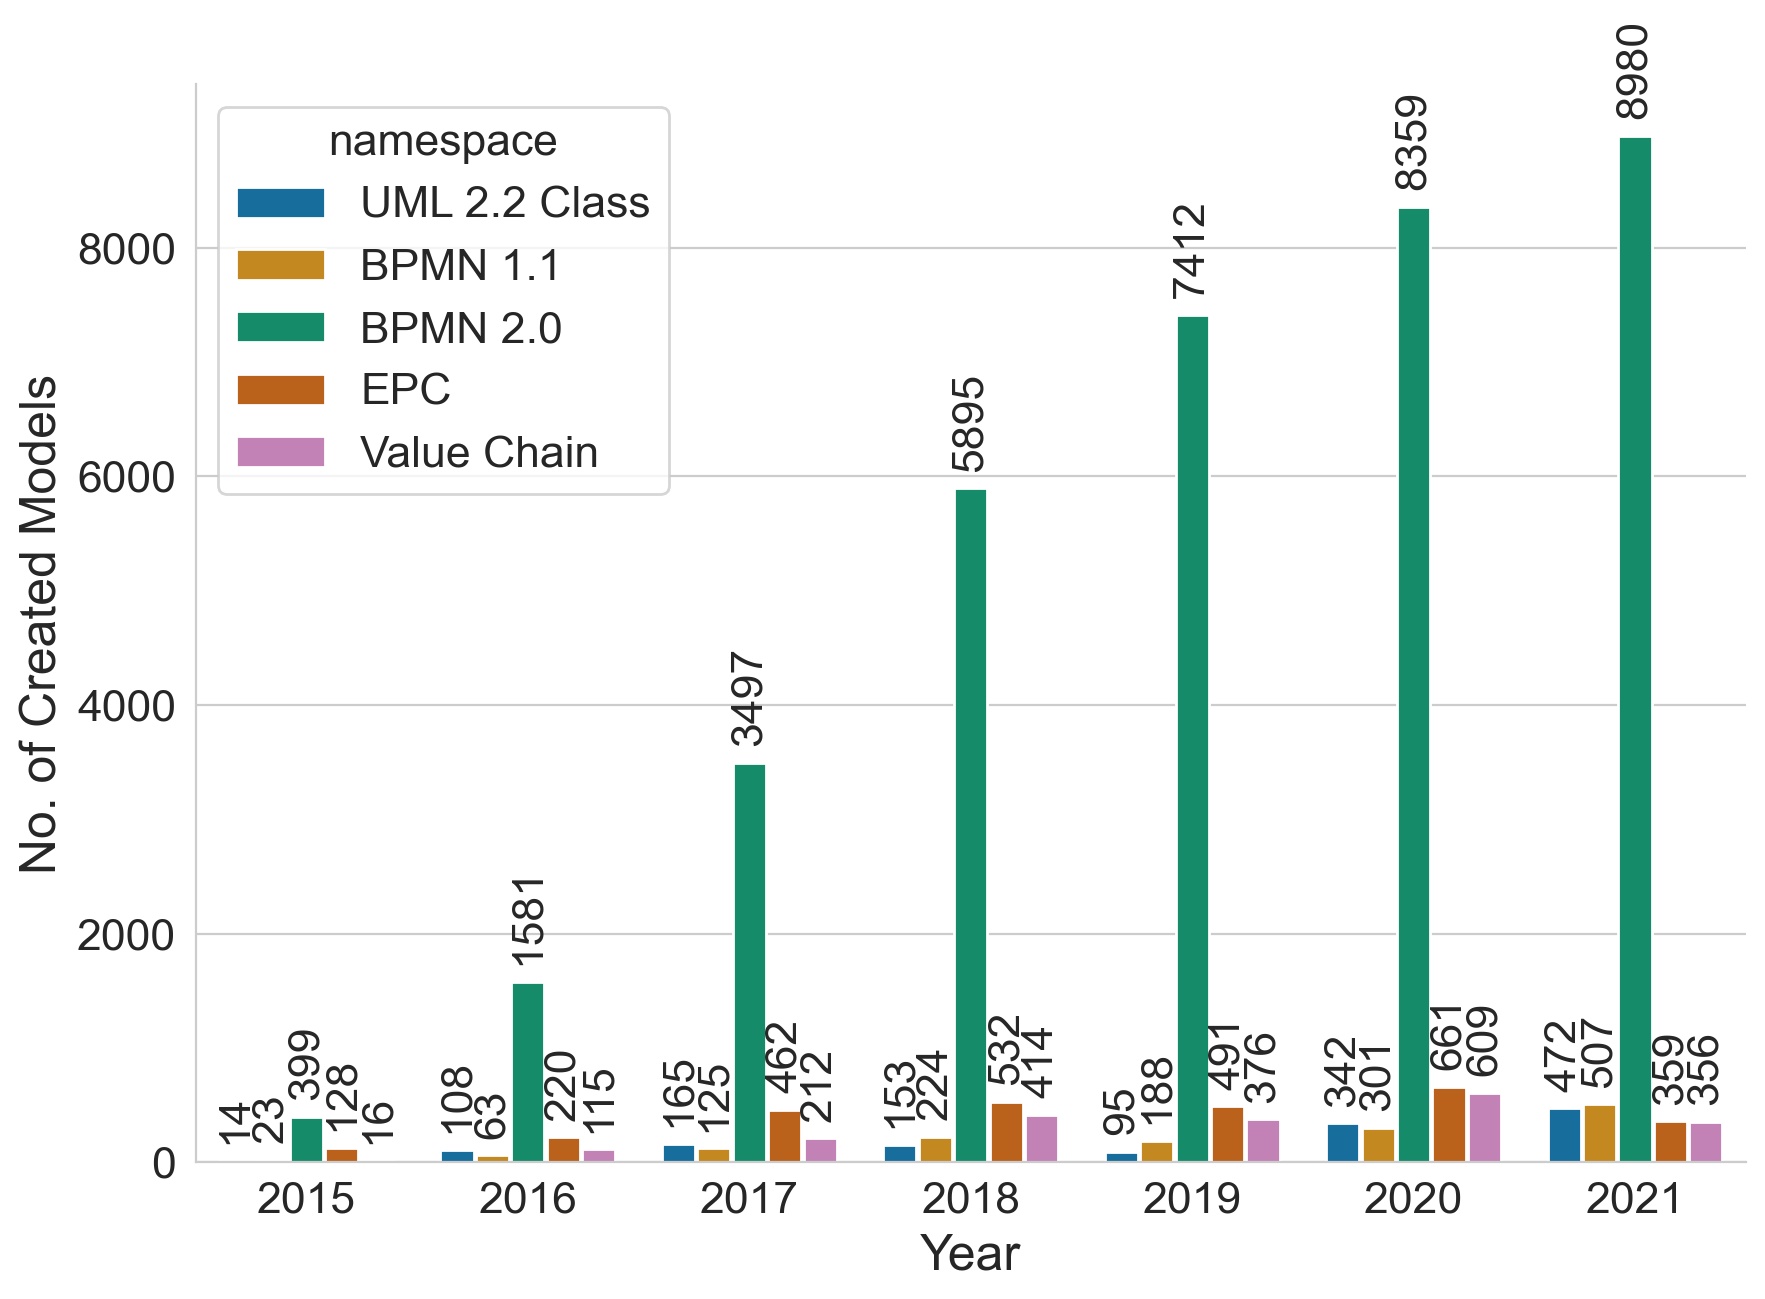

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax)
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0  EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2021      8980  359          356       507            472
2020      8359  661          609       301            342
2019      7412  491          376       188             95
2018      5895  532          414       224            153
2017      3497  462          212       125            165
2016      1581  220          115        63            108
2015       399  128           16        23             14

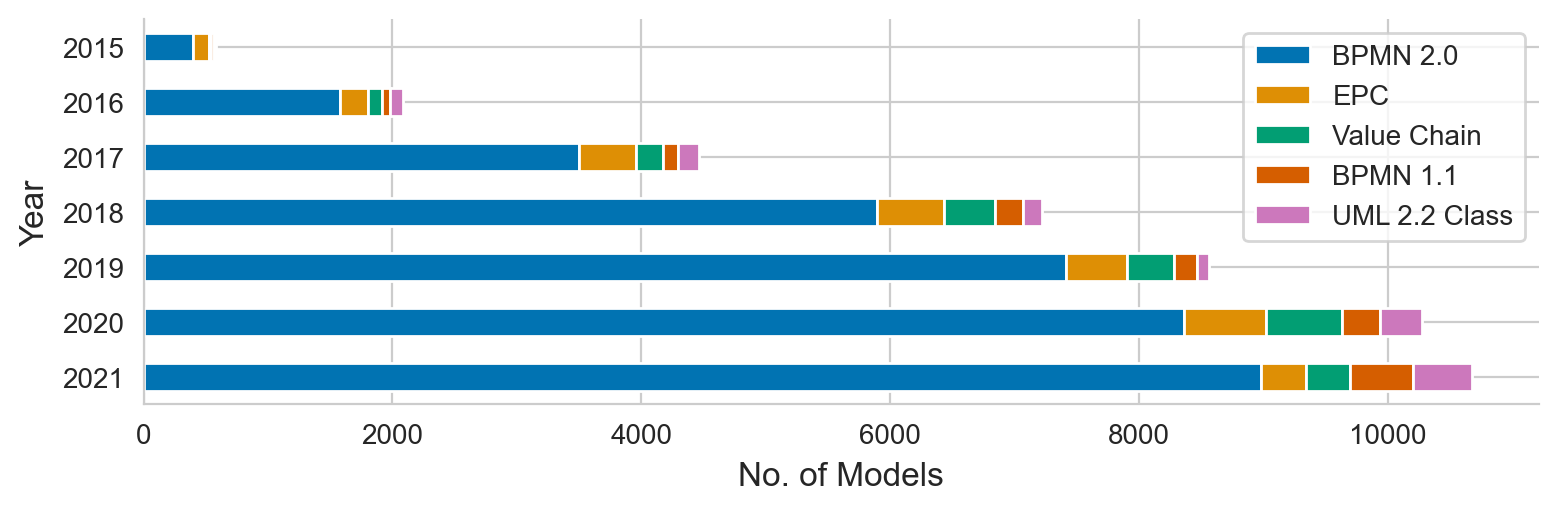

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  6e9a5e67b18041859a70e093d39f61f5   
18ca3b4ea18f4963ba66d54d209c8df6  526a5b11fcec43c1acae71fc85f6e048   
18caebd99fe846daaa9573ca3eba8293  d8fba2417eda4ba08544fcea31a5efeb   
18cb092ef5c64788a7284b0c597fbee8  f0647ea08f944263a482bebe0a0cd2db   
18cb104ce0e341ebad780e6d001342c1  b53ddbff242f45bf96d66facadba8abd   

                                                   organization_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  b687311ab9944ff4aa57f73ef9c8dd11   
18ca3b4ea18f4963ba66d54d209c8df6  c41660388a04449a995dccf97d894f46   
18caebd99fe846daaa9573ca3eba8293  c41660388a04449a995dccf97d894f46   
18cb092ef5c64788a7284b0c597fbee8  9fa5c4b022714032b1343aa6e69b7181   
18cb104ce0e341ebad780e6d001342c1  38ebf1ca95094fbaa4dbf0e7d6572191   

                                            datetime description  \
model_id                                                           
18ca3235ecba415da2e24298878ca872 2019-09-03 00:49:15         NaN   
18ca3b4ea18f4963ba66d54d209c8df6 2019-06-12 02:19:30         NaN   
18caebd99fe846daaa9573ca3eba8293 2019-06-03 20:09:08         NaN   
18cb092ef5c64788a7284b0c597fbee8 2020-05-23 14:48:59         NaN   
18cb104ce0e341ebad780e6d001342c1 2018-04-06 07:35:32         NaN   

                                                     name type  \
model_id                                                         
18ca3235ecba415da2e24298878ca872               Guidelines  NaN   
18ca3b4ea18f4963ba66d54d209c8df6            12345678_rev1  NaN   
18caebd99fe846daaa9573ca3eba8293            12345678_rev3  NaN   
18cb092ef5c64788a7284b0c597fbee8                       35  NaN   
18cb104ce0e341ebad780e6d001342c1  515-IFN-BPM Assignment1  NaN   

                                                            namespace  
model_id                                                               
18ca3235ecba415da2e24298878ca872  http://b3mn.org/stencilset/bpmn2.0#  
18ca3b4ea18f4963ba66d54d209c8df6  http://b3mn.org/stencilset/bpmn2.0#  
18caebd99fe846daaa9573ca3eba8293  http://b3mn.org/stencilset/bpmn2.0#  
18cb092ef5c64788a7284b0c597fbee8  http://b3mn.org/stencilset/bpmn2.0#  
18cb104ce0e341ebad780e6d001342c1  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

36123

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [34]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.94s/it]


category  \
model_id                         element_id                                               
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6  SequenceFlow   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541  SequenceFlow   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC  SequenceFlow   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F  SequenceFlow   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127  SequenceFlow   

                                                                          label  \
model_id                         element_id                                       
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6   Yes   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541    No   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC    No   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F   Yes   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6             None   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541             None   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC             None   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F             None   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127             None   

                                                                                 name  
model_id                         element_id                                            
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6  Guidelines  
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541  Guidelines  
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC  Guidelines  
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F  Guidelines  
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127  Guidelines

Number of BPMN 2.0 models from the parser:

In [35]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

54061

Number of BPMN 2.0 models from the parser after filtering out example processes, models with less than 5 elements, and models with no task, start event or end event elements:

In [36]:
df_bpmn = DataFilter(df_bpmn).filter_data("example_processes_bpmn")
df_bpmn = DataFilter(df_bpmn).filter_data("models", 5)

Filtering out example processes models...
Keeping 34977 out of 54061 from the dataset
Dataset has been filtered down to 34977 models, a decrease of 35.30%.

Filtering out models with less than 5 elements...
Keeping 34564 out of 34977 from the dataset
Filtering out models with no start, end, or task elements...
Keeping 24721 out of 34564 from the dataset

Dataset has been filtered down to 24721 models, a decrease of 29.32%.


When compared to the analysis of the dataset metadata, we notice that after the example processes filtering, the count of BPMN 2.0 models is slightly lower. This difference shows there are some empty BPMN 2.0 models in the dataset, which do not contain any elements and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [37]:
len(df_bpmn)

1300125

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [38]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [39]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 24721/24721 [07:16<00:00, 56.64it/s]


label  \
model_id                                                                              
0a1f6a48a89446fe8d4bcdb5fb1c1f6c   ja nein Zahlungsdatum Datum für nächstes Ausz...   
0a1fb922e8f24db8ad264b70160a4101   No Gestionar Destinación de Ahorros BEPS \n\n...   
0a1fded155294cfd8f08c22a66dec40a  Mismatches exist but can be corrected Mismatch...   
0a2033822ffa4f6da9bf075f115b387c   student napustanje sale predaja zadataka [2h]...   
0a20539818604b53bf8bbf9a7ca6d9fb   Yes No Purchasing Bid Set to cancelled Bid se...   

                                                                               name  \
model_id                                                                              
0a1f6a48a89446fe8d4bcdb5fb1c1f6c  UnterProzess &quot;Teilbetragauszahlen (WF Ein...   
0a1fb922e8f24db8ad264b70160a4101                   Proceso Otorgamiento Real (Copy)   
0a1fded155294cfd8f08c22a66dec40a                                 Figure3.4_Jane Doe   
0a2033822ffa4f6da9bf075f115b387c                                              1.zad   
0a20539818604b53bf8bbf9a7ca6d9fb                                      Refurbishment   

                                 detected_natural_language  
model_id                                                    
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                        de  
0a1fb922e8f24db8ad264b70160a4101                        es  
0a1fded155294cfd8f08c22a66dec40a                        en  
0a2033822ffa4f6da9bf075f115b387c                        hr  
0a20539818604b53bf8bbf9a7ca6d9fb                        en

Let's plot the use of different languages across the dataset.

In [40]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [41]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English          11919
1                       German           6563
2                      Italian           1249
3                      Spanish           1093
4                     Croatian            685
5                   Portuguese            434
6                       French            421
7                     Estonian            350
8                        Dutch            310
9                    Slovenian            297
10                    Romanian            241
11                  Indonesian            186
12                     Swedish            156
13                       Greek            124
14  Unknown language [UNKNOWN]            113
15                   Hungarian             90
16                      Polish             87
17                     Turkish             34
18                      Danish             33
19                   Norwegian             32
20                     Finnish             30
21                     Catalan             30
22                  Vietnamese             28
23                       Welsh             27
24                    Japanese             27
25                   Afrikaans             23
26    Unknown language [zh-cn]             19
27                       Czech             18
28                    Albanian             16
29                      Somali             13
30                     Tagalog             13
31                     Russian             12
32                      Slovak             10
33                     Latvian             10
34                  Lithuanian             10
35                      Korean              9
36                  Macedonian              6
37                     Swahili              3

We only plot the 10 most common languages.

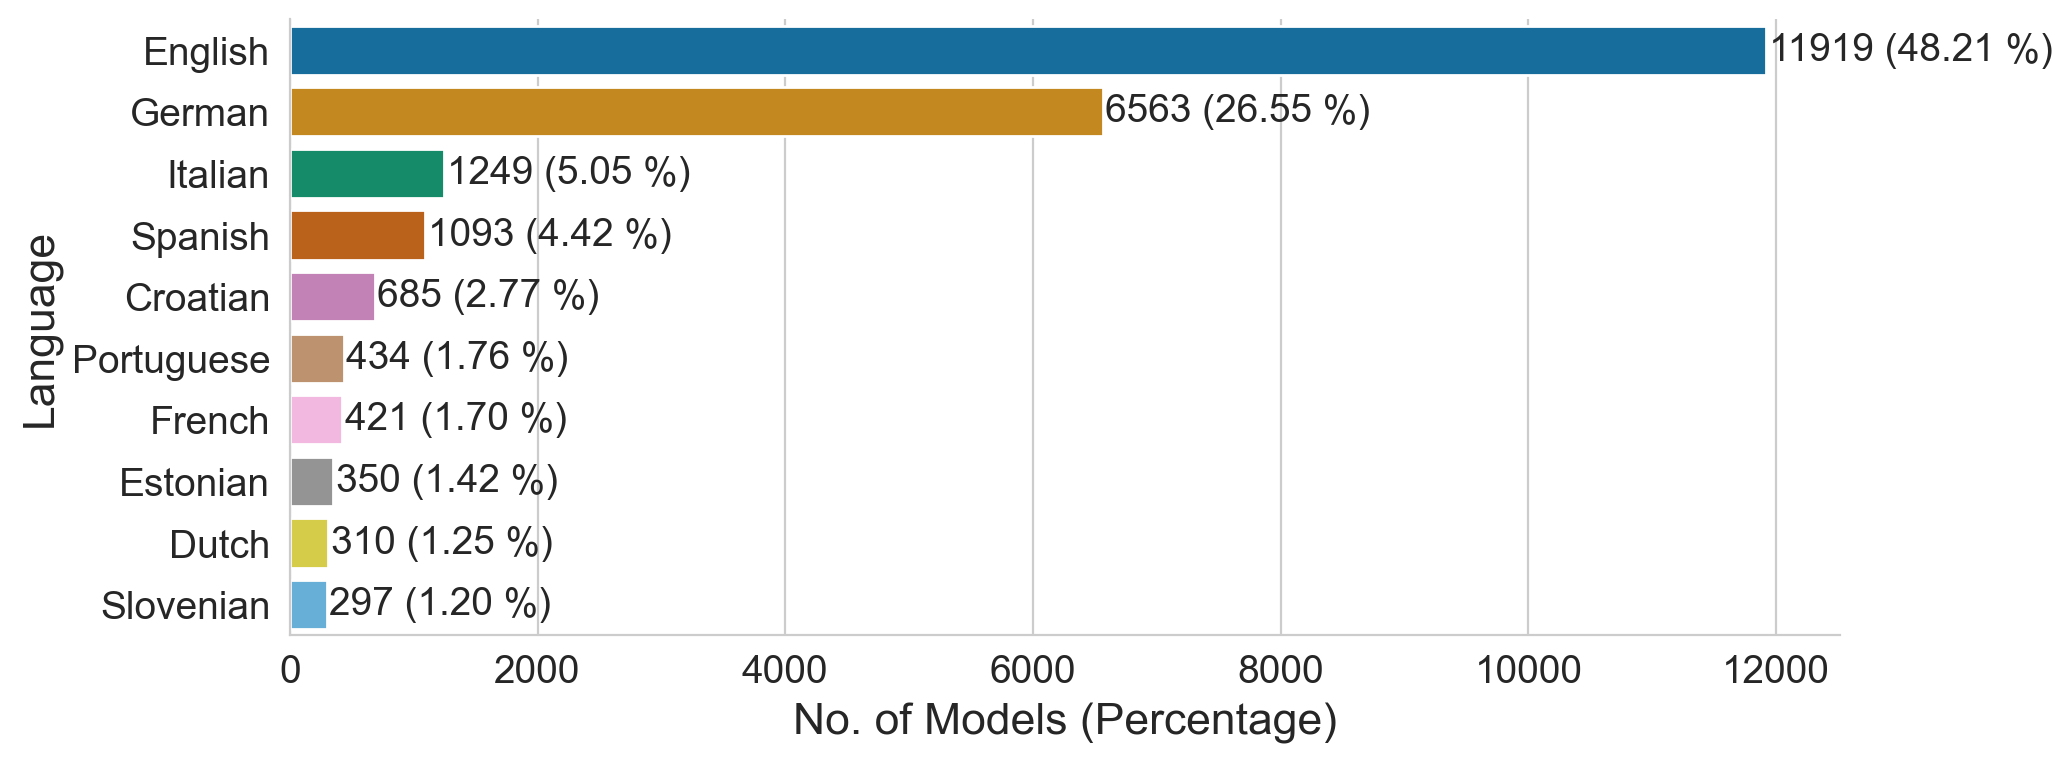

In [42]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", hue="Language", data=df_lang)
labels = [f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
#ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=)
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [43]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [44]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24721/24721 [00:04<00:00, 5597.68it/s]


Association_Undirected  SequenceFlow  Pool  Lane  TextAnnotation  \
0                       1             8     1     1               1   
1                       0            67     1     6               1   
2                       0            10     0     0               0   
3                       0            24     1     2               0   
4                       0            24     8     8               0   

   IntermediateTimerEvent  Task  EndNoneEvent  Exclusive_Databased_Gateway  \
0                       1     3             1                            2   
1                       0    25             2                           12   
2                       0     5             1                            2   
3                       0    11             1                            0   
4                       0    26             2                            4   

   StartNoneEvent  total_count  Association_Unidirectional  \
0               1           20                           0   
1               1          129                           3   
2               1           19                           0   
3               1           53                           1   
4               1           81                           0   

   CollapsedSubprocess  ParallelGateway  InclusiveGateway  \
0                    0                0                 0   
1                    6                4                 1   
2                    0                0                 0   
3                    1                3                 3   
4                    0                0                 0   

   IntermediateLinkEventCatching  StartErrorEvent  StartTimerEvent  \
0                              0                0                0   
1                              0                0                0   
2                              0                0                0   
3                              1                1                1   
4                              0                0                0   

   IntermediateLinkEventThrowing  DataStore  MessageFlow  \
0                              0          0            0   
1                              0          0            0   
2                              0          0            0   
3                              1          1            0   
4                              0          0            8   

   IntermediateMessageEventCatching  IntermediateMessageEventThrowing  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   EventbasedGateway  CollapsedPool  IntermediateEvent  EndErrorEvent  \
0                  0              0                  0              0   
1                  0              0                  0              0   
2                  0              0                  0              0   
3                  0              0                  0              0   
4                  0              0                  0              0   

   IntermediateErrorEvent  IntermediateEscalationEvent  \
0                       0                            0   
1                       0                            0   
2                       0                            0   
3                       0                            0   
4                       0                            0   

   IntermediateSignalEventThrowing  ITSystem  IntermediateSignalEventCatching  \
0                                0         0                                0   
1                                0         0                                0   
2                                0         0                                0   
3                                0

These are the statistics of the different element types per model:

In [45]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    24721.000000
mean         9.951782
std          4.053847
min          4.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         40.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [46]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                          0   
0a1fb922e8f24db8ad264b70160a4101                          0   
0a1fded155294cfd8f08c22a66dec40a                          0   
0a2033822ffa4f6da9bf075f115b387c                          0   
0a20539818604b53bf8bbf9a7ca6d9fb                          0   

category                          Association_Undirected  \
model_id                                                   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                       1   
0a1fb922e8f24db8ad264b70160a4101                       0   
0a1fded155294cfd8f08c22a66dec40a                       0   
0a2033822ffa4f6da9bf075f115b387c                       0   
0a20539818604b53bf8bbf9a7ca6d9fb                       0   

category                          Association_Unidirectional  \
model_id                                                       
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                           0   
0a1fb922e8f24db8ad264b70160a4101                           3   
0a1fded155294cfd8f08c22a66dec40a                           0   
0a2033822ffa4f6da9bf075f115b387c                           1   
0a20539818604b53bf8bbf9a7ca6d9fb                           0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                         0              0   
0a1fb922e8f24db8ad264b70160a4101                         0              0   
0a1fded155294cfd8f08c22a66dec40a                         0              0   
0a2033822ffa4f6da9bf075f115b387c                         0              0   
0a20539818604b53bf8bbf9a7ca6d9fb                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                    0                      0   
0a1fb922e8f24db8ad264b70160a4101                    6                      0   
0a1fded155294cfd8f08c22a66dec40a                    0                      0   
0a2033822ffa4f6da9bf075f115b387c                    1                      0   
0a20539818604b53bf8bbf9a7ca6d9fb                    0                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
0a1f6a48a89446fe8d4bcdb5fb1c1f6c               0           0          0   
0a1fb922e8f24db8ad264b70160a4101               0           0          0   
0a1fded155294cfd8f08c22a66dec40a               0           0          0   
0a2033822ffa4f6da9bf075f115b387c               0           0          1   
0a20539818604b53bf8bbf9a7ca6d9fb               0           0          0   

category                          EndCancelEvent  EndCompensationEvent  \
model_id                                                                 
0a1f6a48a89446fe8d4bcdb5fb1c1f6c               0                     0   
0a1fb922e8f24db8ad264b70160a4101               0                     0   
0a1fded155294cfd8f08c22a66dec40a               0                     0   
0a2033822ffa4f6da9bf075f115b387c               0                     0   
0a20539818604b53bf8bbf9a7ca6d9fb               0                     0   

category                          EndErrorEvent  EndEscalationEvent  \
model_id                                                              
0a1f6a48a89446fe8d4bcdb5fb1c1f6c              0                   0   
0a1fb922e8f24db8ad264b70160a4101              0                   0   
0a1fded155294cfd8f08c22a66dec40a              0                   0   
0a2033822ffa4f6da9bf075f115b387c              0                   0   
0a20539818604b53bf8bbf9a7ca6d9fb              0                   0   

category                          EndMessage

In [47]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [48]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
df_freq[df_freq["frequency"]/len(df_cnts) < 0.1].head()

category  frequency
22         EndMessageEvent       2227
23              Subprocess       2155
24        InclusiveGateway       1988
25       EndTerminateEvent       1093
26  IntermediateErrorEvent       1085

In [49]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())

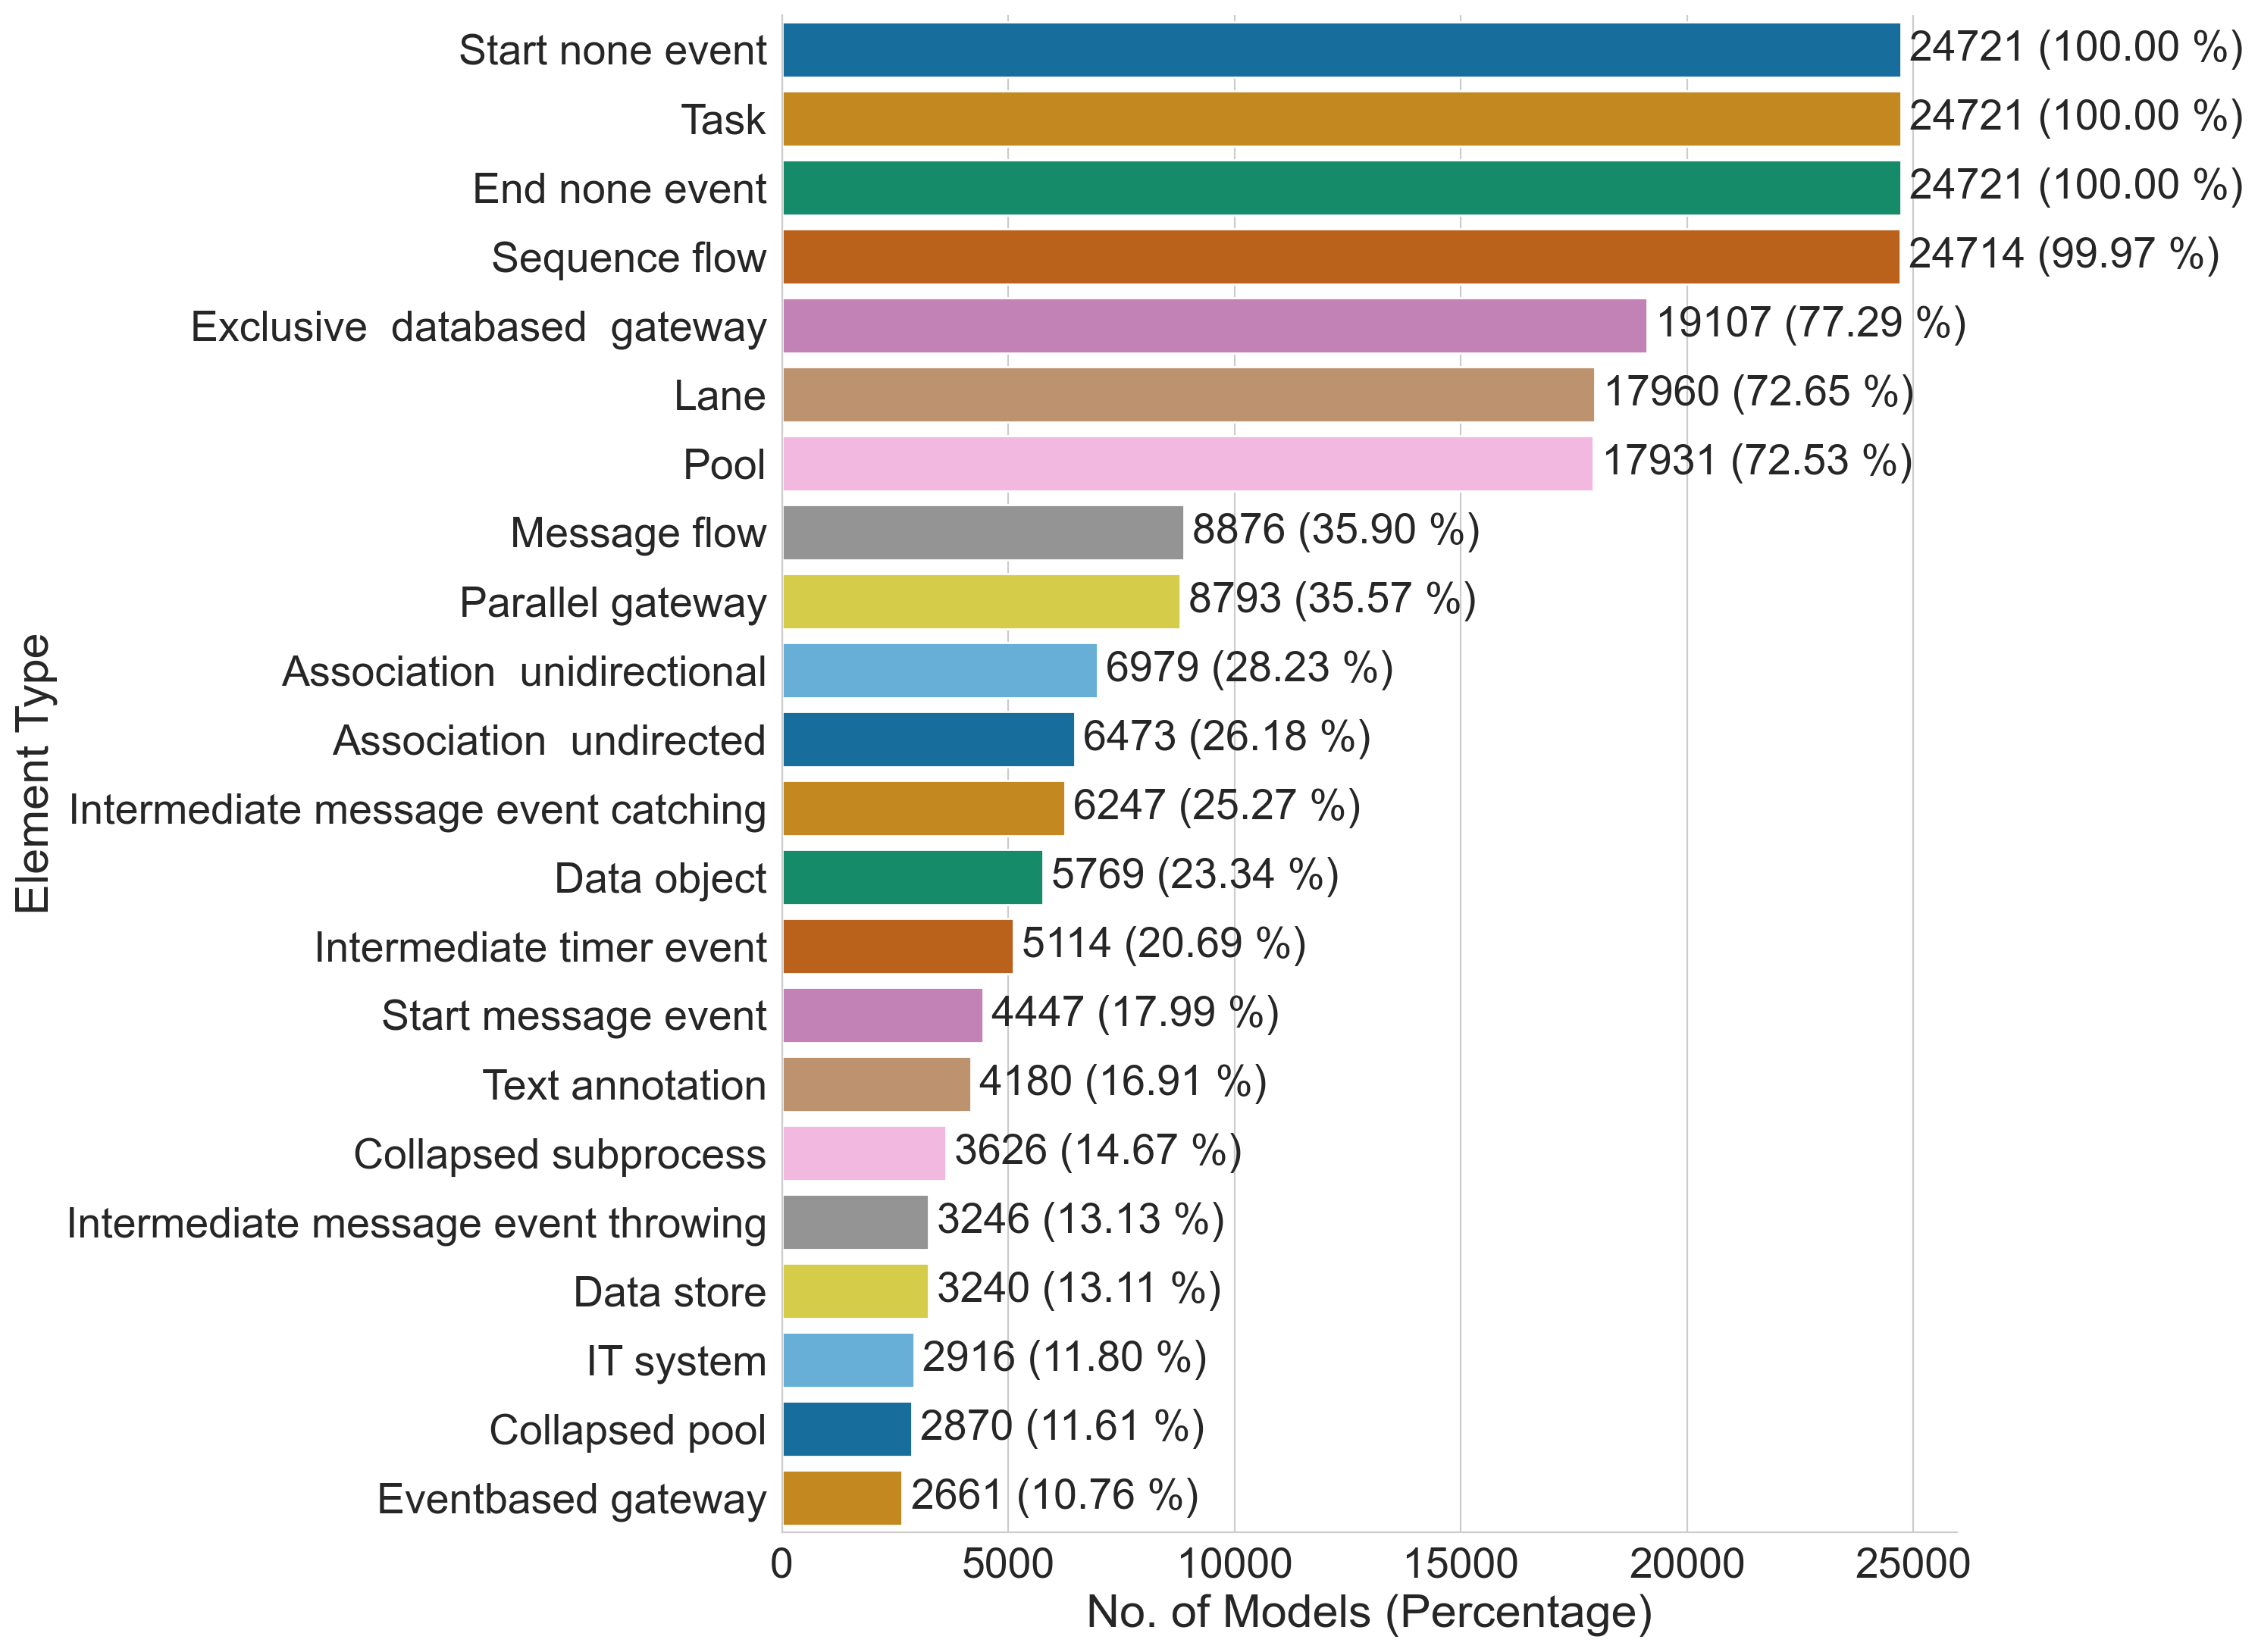

In [50]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
containers_nb = df_freq['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown, maybe pandas v2 is necessary?
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.barplot(x="frequency", y="category",hue="category", legend=False, data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
else:
    ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
total = len(df_cnts)
labels = [f'{val} ({val / total * 100.0:.2f} %)' for val in df_freq['frequency']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [51]:
df_bpmn.head()

category  \
model_id                         element_id                                                         
0a1f6a48a89446fe8d4bcdb5fb1c1f6c sid-A78C6B5F-0399-40C4-BBFD-5EAA58D64994  Association_Undirected   
                                 sid-F22CEDF7-0ABE-4179-AABD-CA033DD8F5FE            SequenceFlow   
                                 sid-BDE1BFC0-D158-45EF-A31C-72C118DB3291            SequenceFlow   
                                 sid-C2F747CE-8DF9-41AB-8F30-CB410B4DCACA            SequenceFlow   
                                 sid-CDEF46F9-3996-4825-BDE3-B7A61B6F2C97            SequenceFlow   

                                                                          label  \
model_id                         element_id                                       
0a1f6a48a89446fe8d4bcdb5fb1c1f6c sid-A78C6B5F-0399-40C4-BBFD-5EAA58D64994  None   
                                 sid-F22CEDF7-0ABE-4179-AABD-CA033DD8F5FE    ja   
                                 sid-BDE1BFC0-D158-45EF-A31C-72C118DB3291         
                                 sid-C2F747CE-8DF9-41AB-8F30-CB410B4DCACA         
                                 sid-CDEF46F9-3996-4825-BDE3-B7A61B6F2C97  nein   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
0a1f6a48a89446fe8d4bcdb5fb1c1f6c sid-A78C6B5F-0399-40C4-BBFD-5EAA58D64994             None   
                                 sid-F22CEDF7-0ABE-4179-AABD-CA033DD8F5FE             None   
                                 sid-BDE1BFC0-D158-45EF-A31C-72C118DB3291             None   
                                 sid-C2F747CE-8DF9-41AB-8F30-CB410B4DCACA             None   
                                 sid-CDEF46F9-3996-4825-BDE3-B7A61B6F2C97             None   

                                                                                                                        name  
model_id                         element_id                                                                                   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c sid-A78C6B5F-0399-40C4-BBFD-5EAA58D64994  UnterProzess &quot;Teilbetragauszahlen (WF Ein...  
                                 sid-F22CEDF7-0ABE-4179-AABD-CA033DD8F5FE  UnterProzess &quot;Teilbetragauszahlen (WF Ein...  
                                 sid-BDE1BFC0-D158-45EF-A31C-72C118DB3291  UnterProzess &quot;Teilbetragauszahlen (WF Ein...  
                                 sid-C2F747CE-8DF9-41AB-8F30-CB410B4DCACA  UnterProzess &quot;Teilbetragauszahlen (WF Ein...  
                                 sid-CDEF46F9-3996-4825-BDE3-B7A61B6F2C97  UnterProzess &quot;Teilbetragauszahlen (WF Ein...

First, we calculate and visualize the total counts of business objects in the dataset.

In [52]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [53]:
total_bos_count = len(total_bos)
total_bos_count

9732

In [54]:
len(df_bpmn)

1300125

When compared to the total number of elements, that would be about:

In [55]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.75%


Next, let's take a look at how many models have at least one glossary link.

In [56]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [57]:
len(models_w_bos)

2919

The highest number of glossary links used in one model:

In [58]:
models_w_bos.max()

99

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [59]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

5887

In [60]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

60.49%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

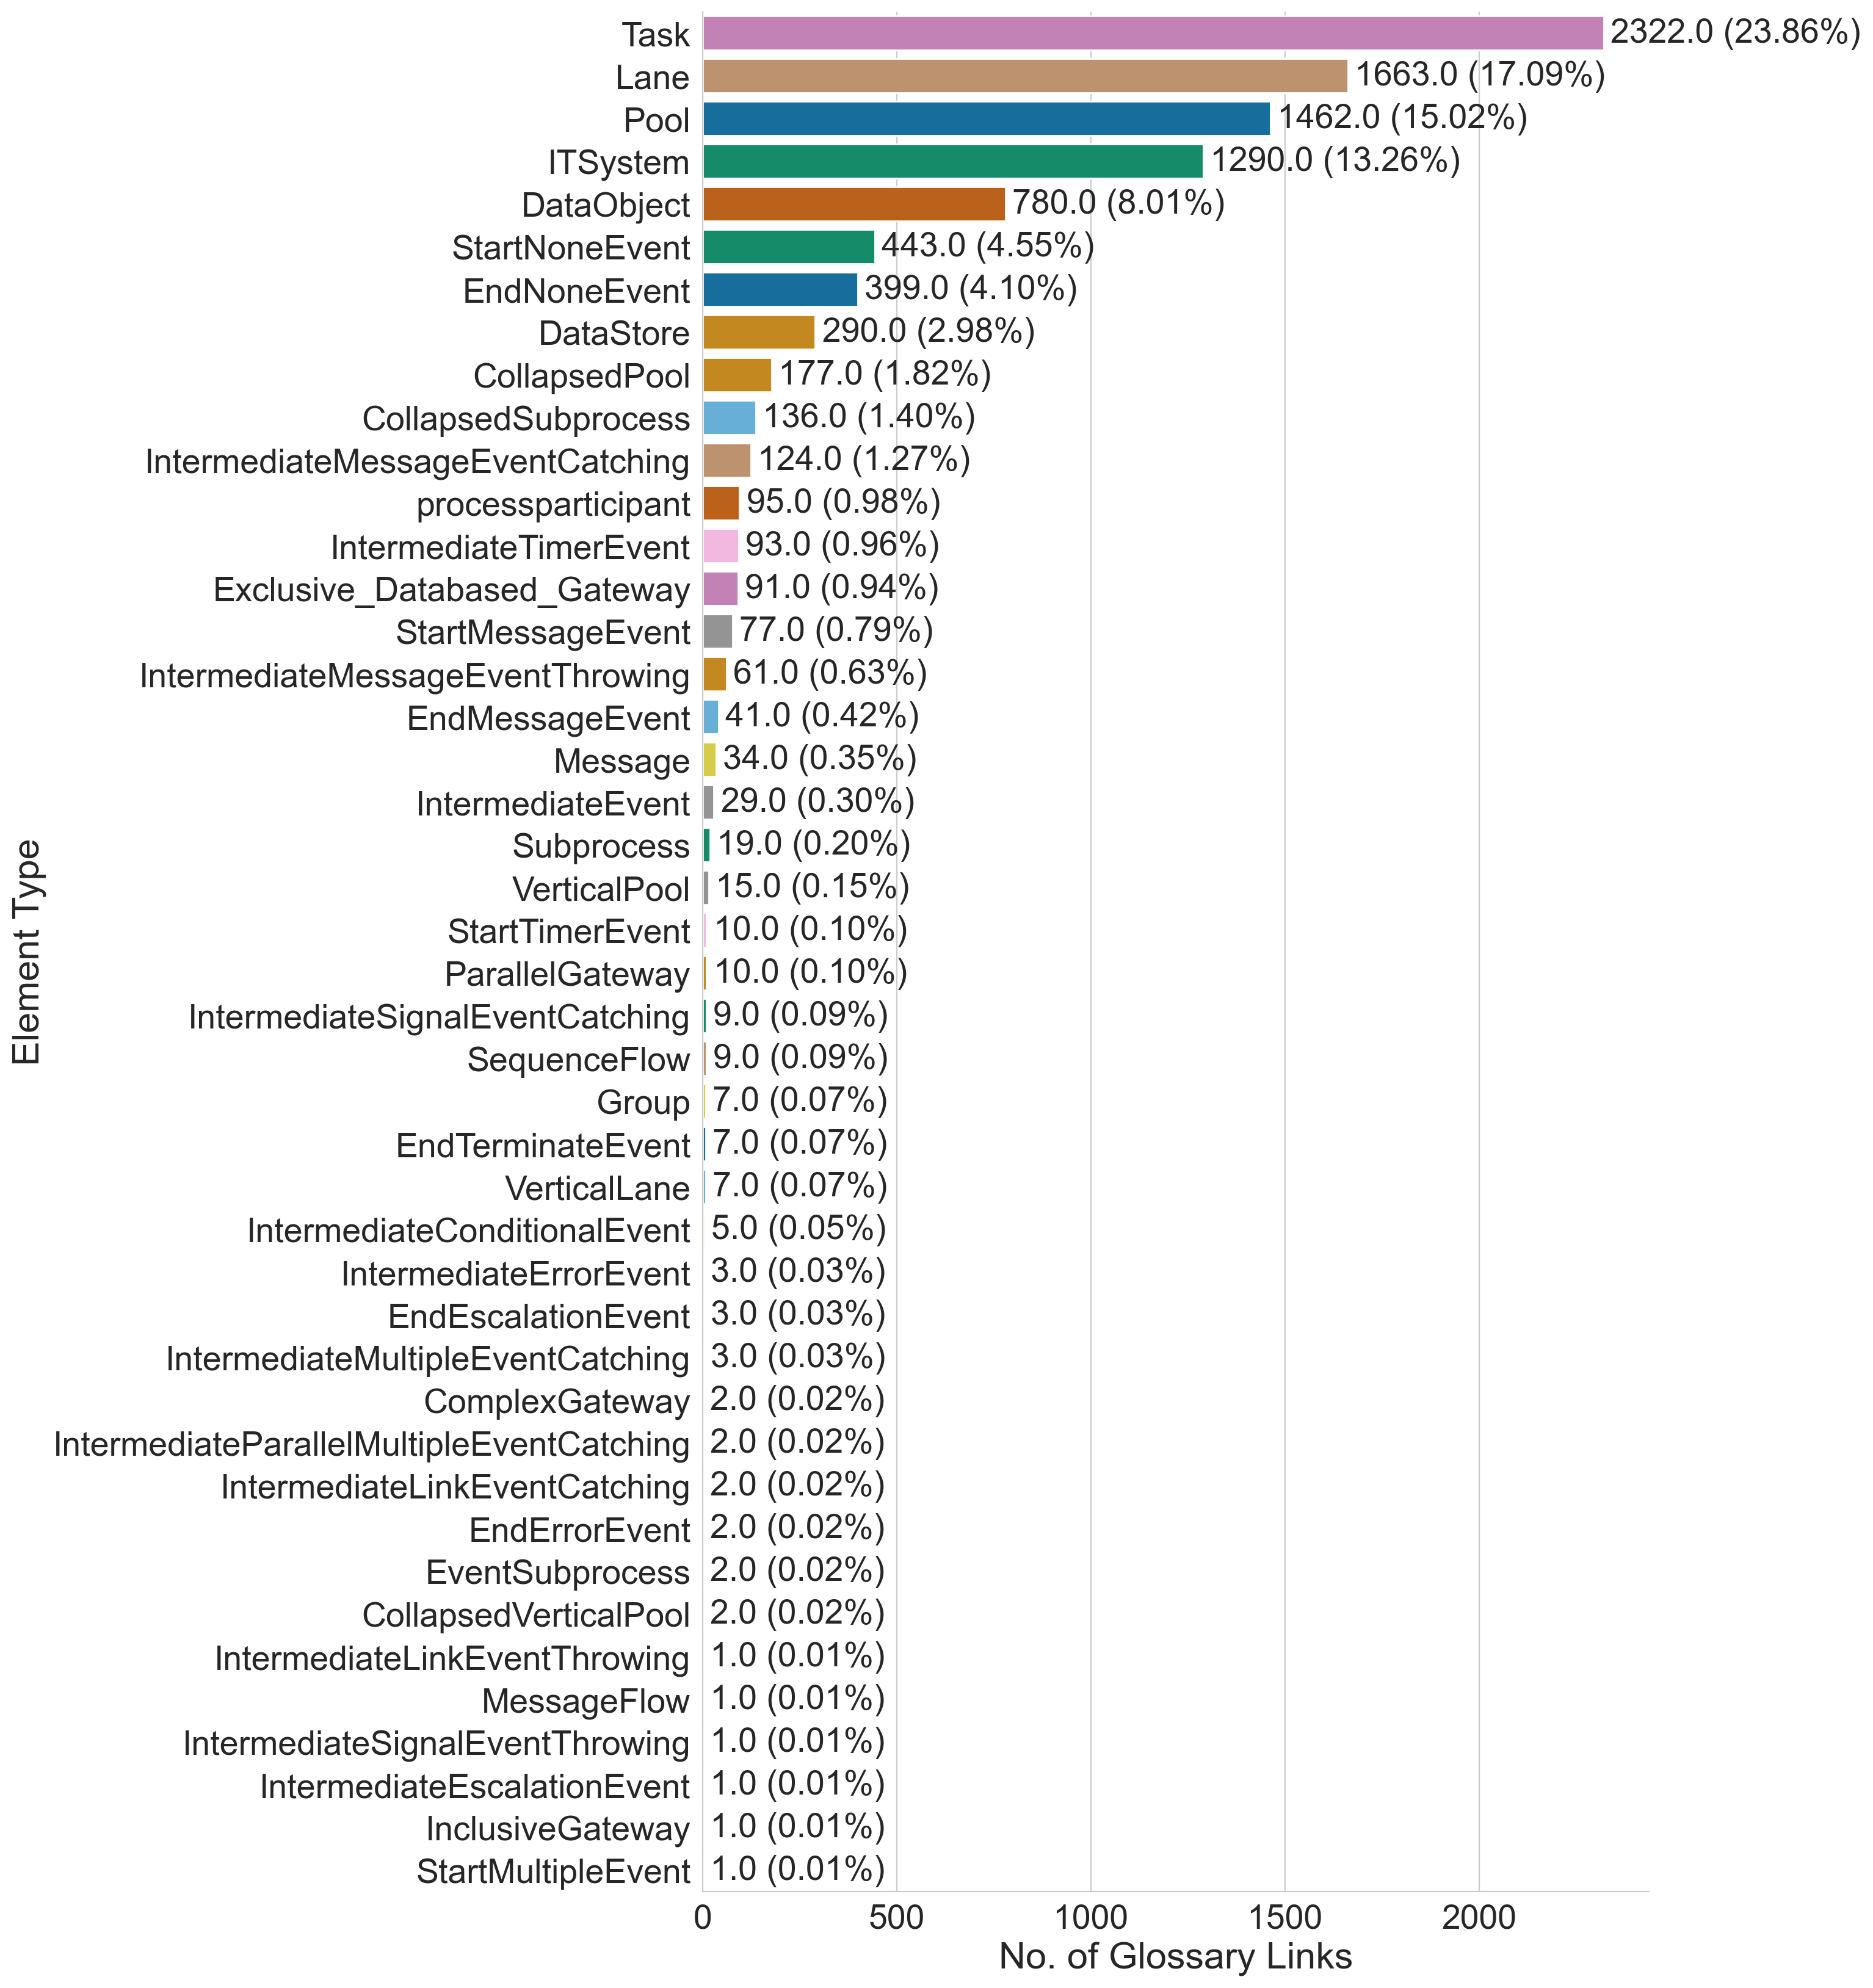

In [61]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
containers_nb = total_bos['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown, maybe pandas v2 is necessary?
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.countplot(y="category", hue="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb),legend=False)
else:
    ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
labels = []
for container in ax.containers:
    for val in container:
        labels.append(f'{val.get_width()} ({val.get_width()/total_bos_count*100.0:.2f}%)')
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particular category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [62]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [63]:
len(its_bos_count)

588

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [64]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

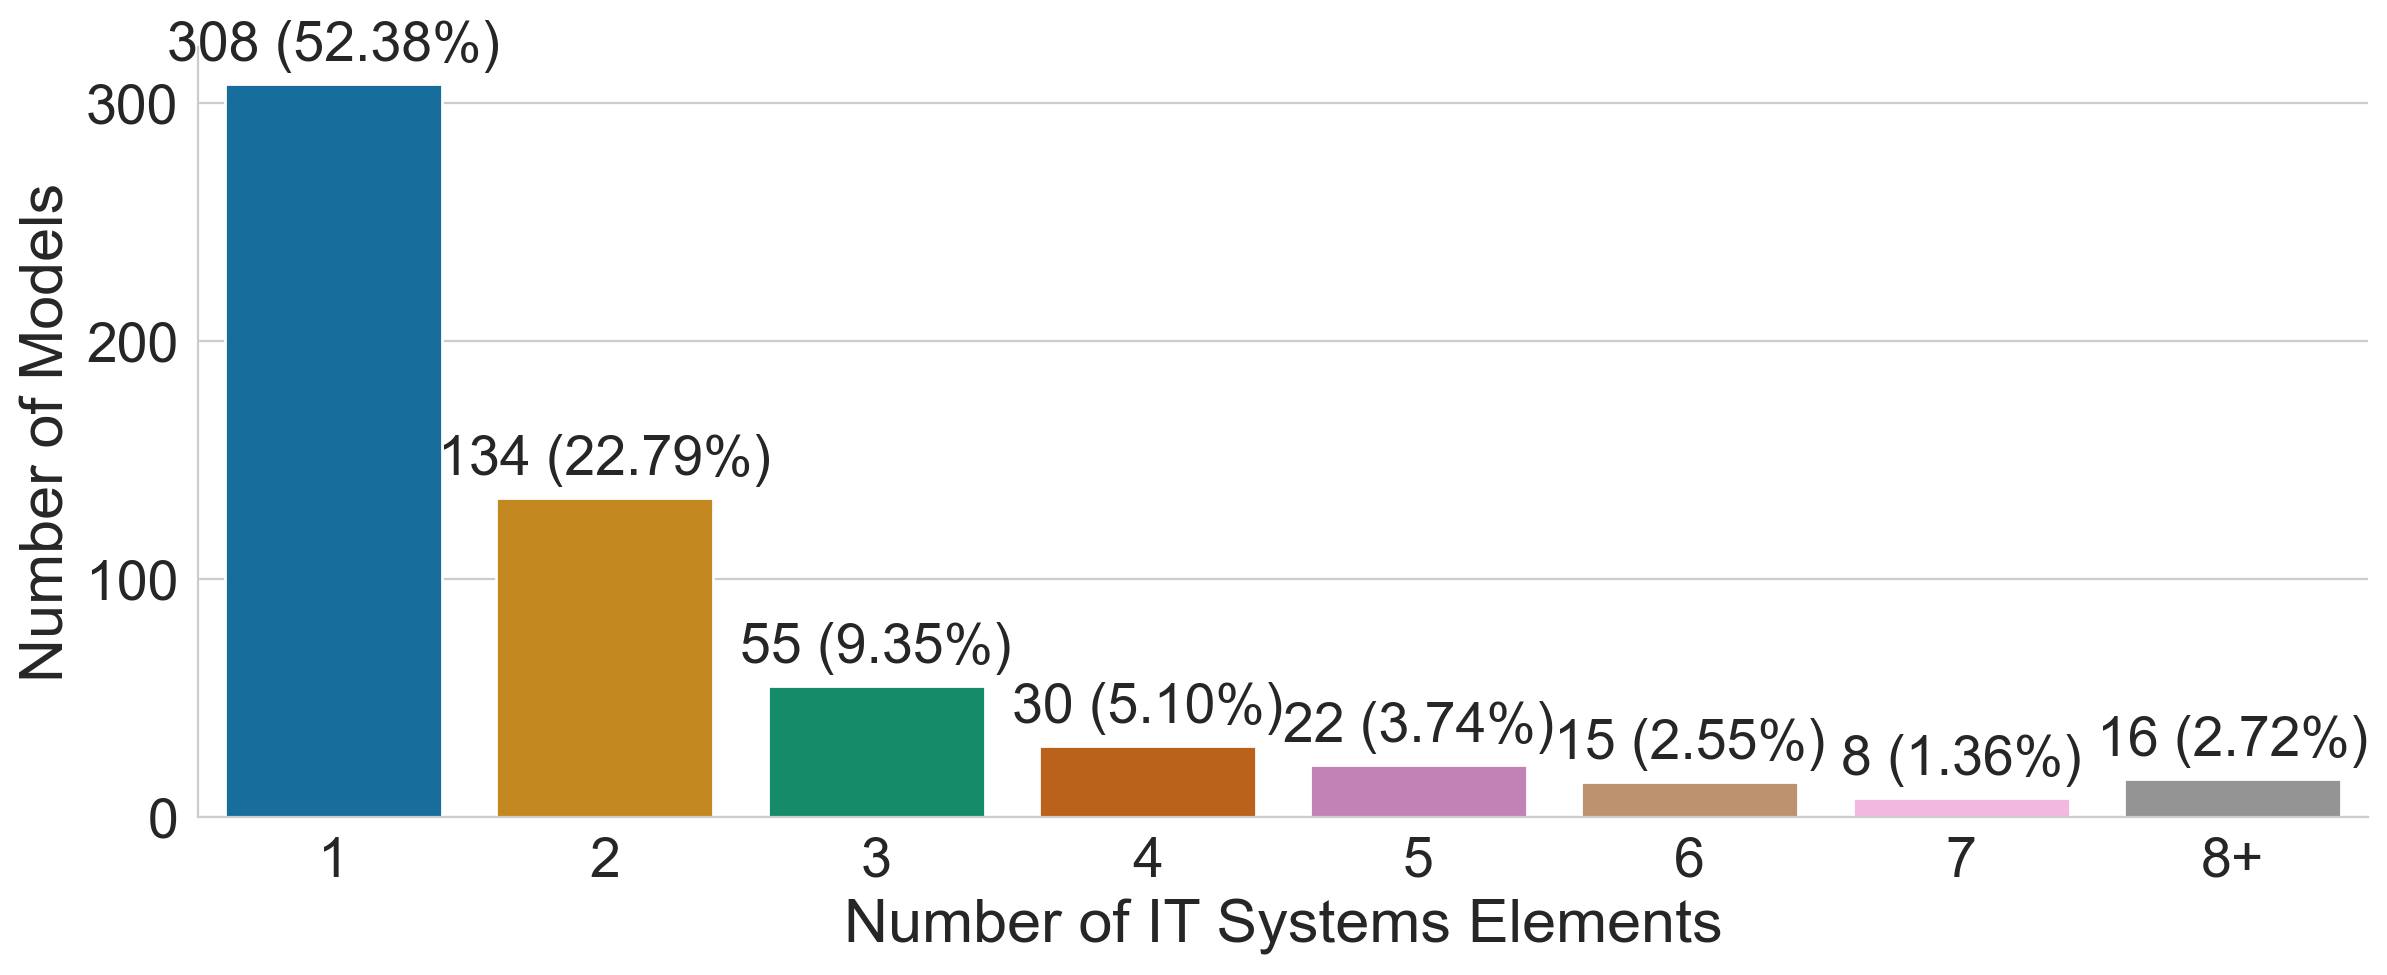

In [65]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos_count)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [66]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()
its_count_per_model

1    511
2     56
3     11
4      7
5      3
Name: glossary_link_id, dtype: int64

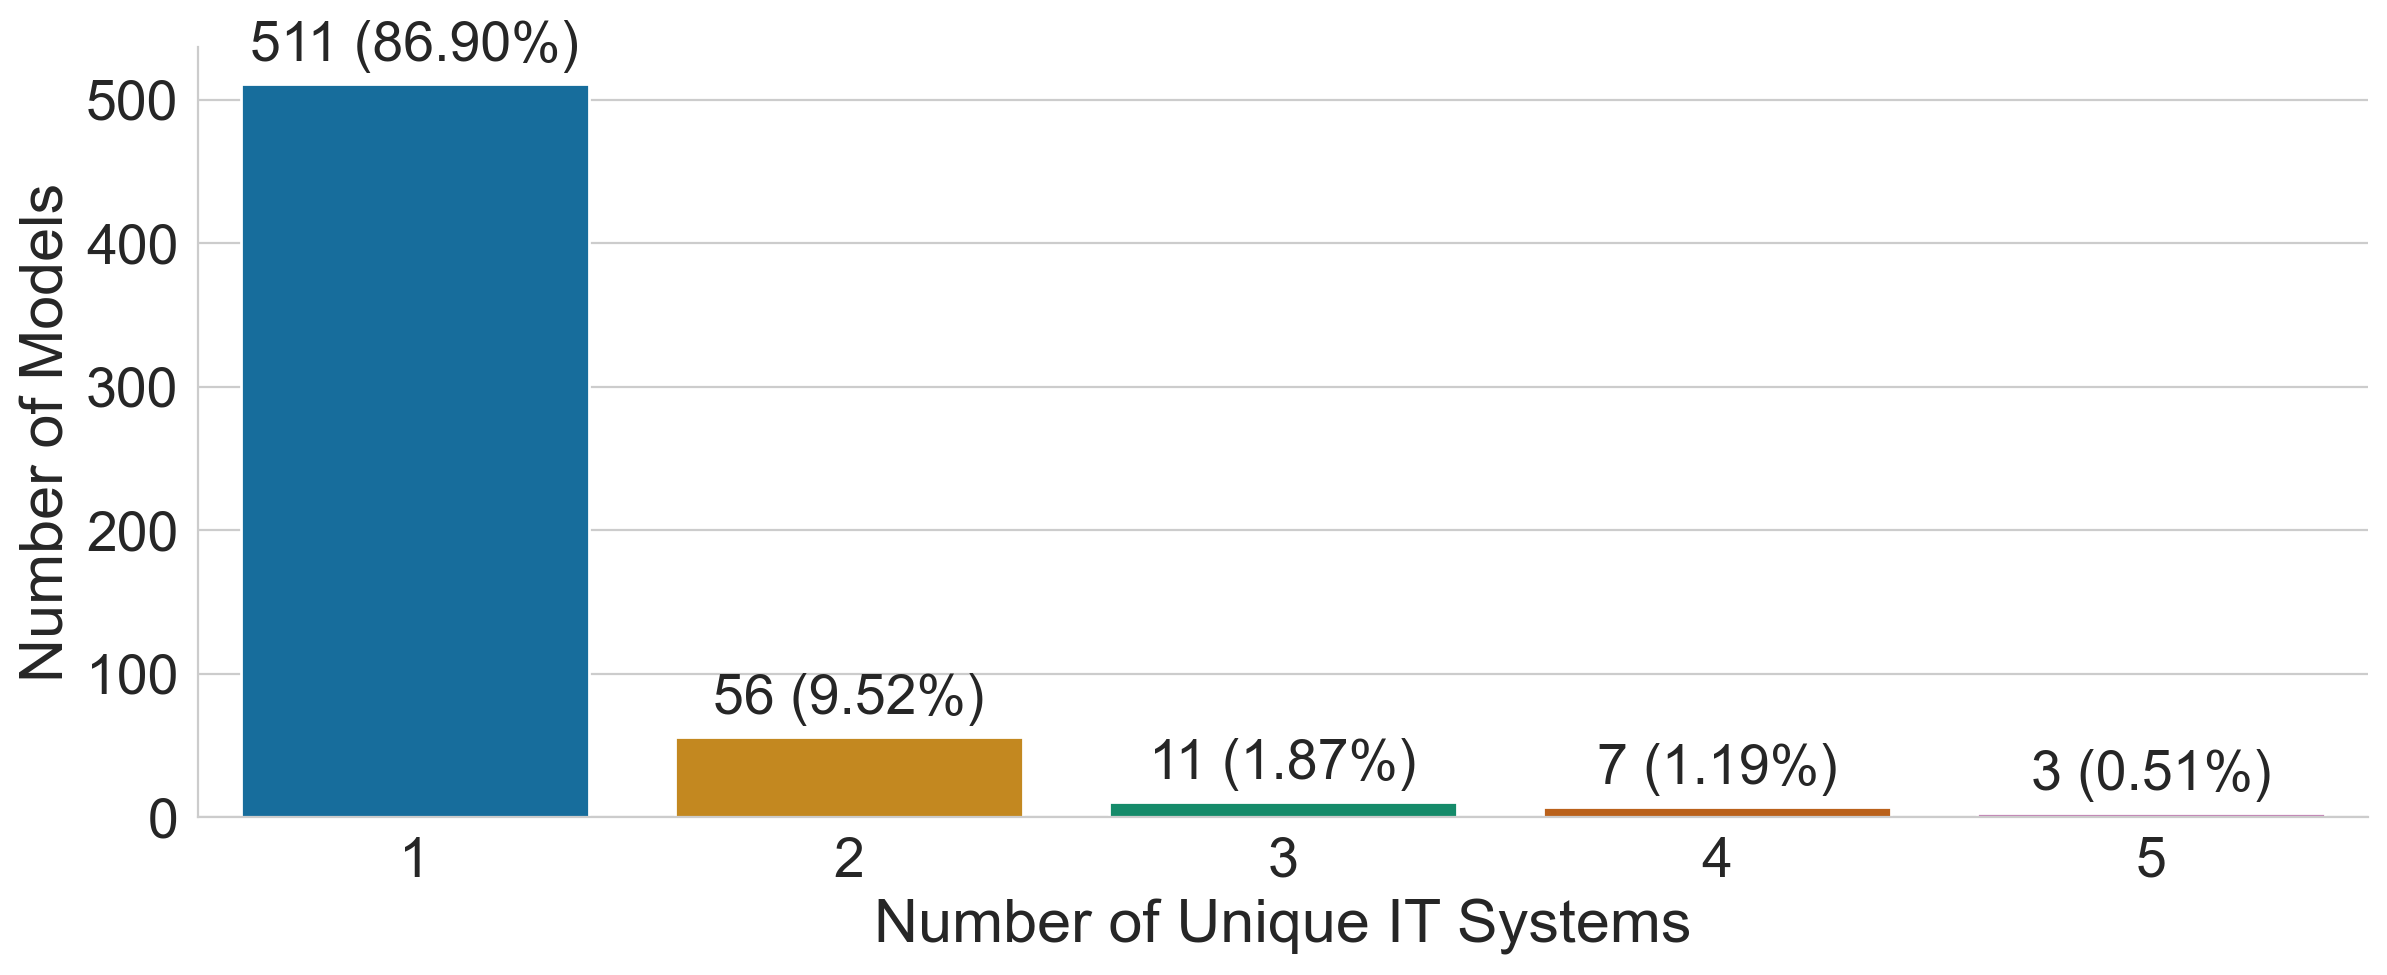

In [67]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As expected, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [68]:
cnt_elements.total_count.describe()

count    24721.000000
mean        52.591926
std         53.759840
min          5.000000
25%         23.000000
50%         40.000000
75%         64.000000
max       2611.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [69]:
cnt_elements.describe().transpose().head()

count       mean        std  min  25%   50%   75%  \
Association_Undirected  24721.0   1.189313   6.017914  0.0  0.0   0.0   1.0   
SequenceFlow            24721.0  21.216901  20.460514  0.0  9.0  16.0  26.0   
Pool                    24721.0   1.178027   1.135509  0.0  0.0   1.0   2.0   
Lane                    24721.0   2.115327   2.032306  0.0  0.0   2.0   3.0   
TextAnnotation          24721.0   0.633834   5.430107  0.0  0.0   0.0   0.0   

                          max  
Association_Undirected  529.0  
SequenceFlow            598.0  
Pool                     24.0  
Lane                     28.0  
TextAnnotation          529.0

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [70]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [71]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%  \
Activities          24721.0  10.743700   9.984442  1.0   5.0   8.0  13.0   
Artifacts           24721.0   1.017232   5.735720  0.0   0.0   0.0   1.0   
Connecting Objects  24721.0  25.763804  28.268782  0.0  11.0  19.0  31.0   
Data Elements       24721.0   1.324785   4.408919  0.0   0.0   0.0   1.0   
Events              24721.0   5.801019   6.639596  2.0   2.0   3.0   7.0   

                       max  
Activities           227.0  
Artifacts            529.0  
Connecting Objects  1393.0  
Data Elements        266.0  
Events               156.0

In [72]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%     max
Activities          10.7  10.0  1.0   5.0   8.0  13.0   227.0
Artifacts            1.0   5.7  0.0   0.0   0.0   1.0   529.0
Connecting Objects  25.8  28.3  0.0  11.0  19.0  31.0  1393.0
Data Elements        1.3   4.4  0.0   0.0   0.0   1.0   266.0
Events               5.8   6.6  2.0   2.0   3.0   7.0   156.0
Gateways             4.4   5.7  0.0   2.0   3.0   6.0   251.0
Swimlanes            3.5   3.1  0.0   0.0   4.0   5.0    48.0

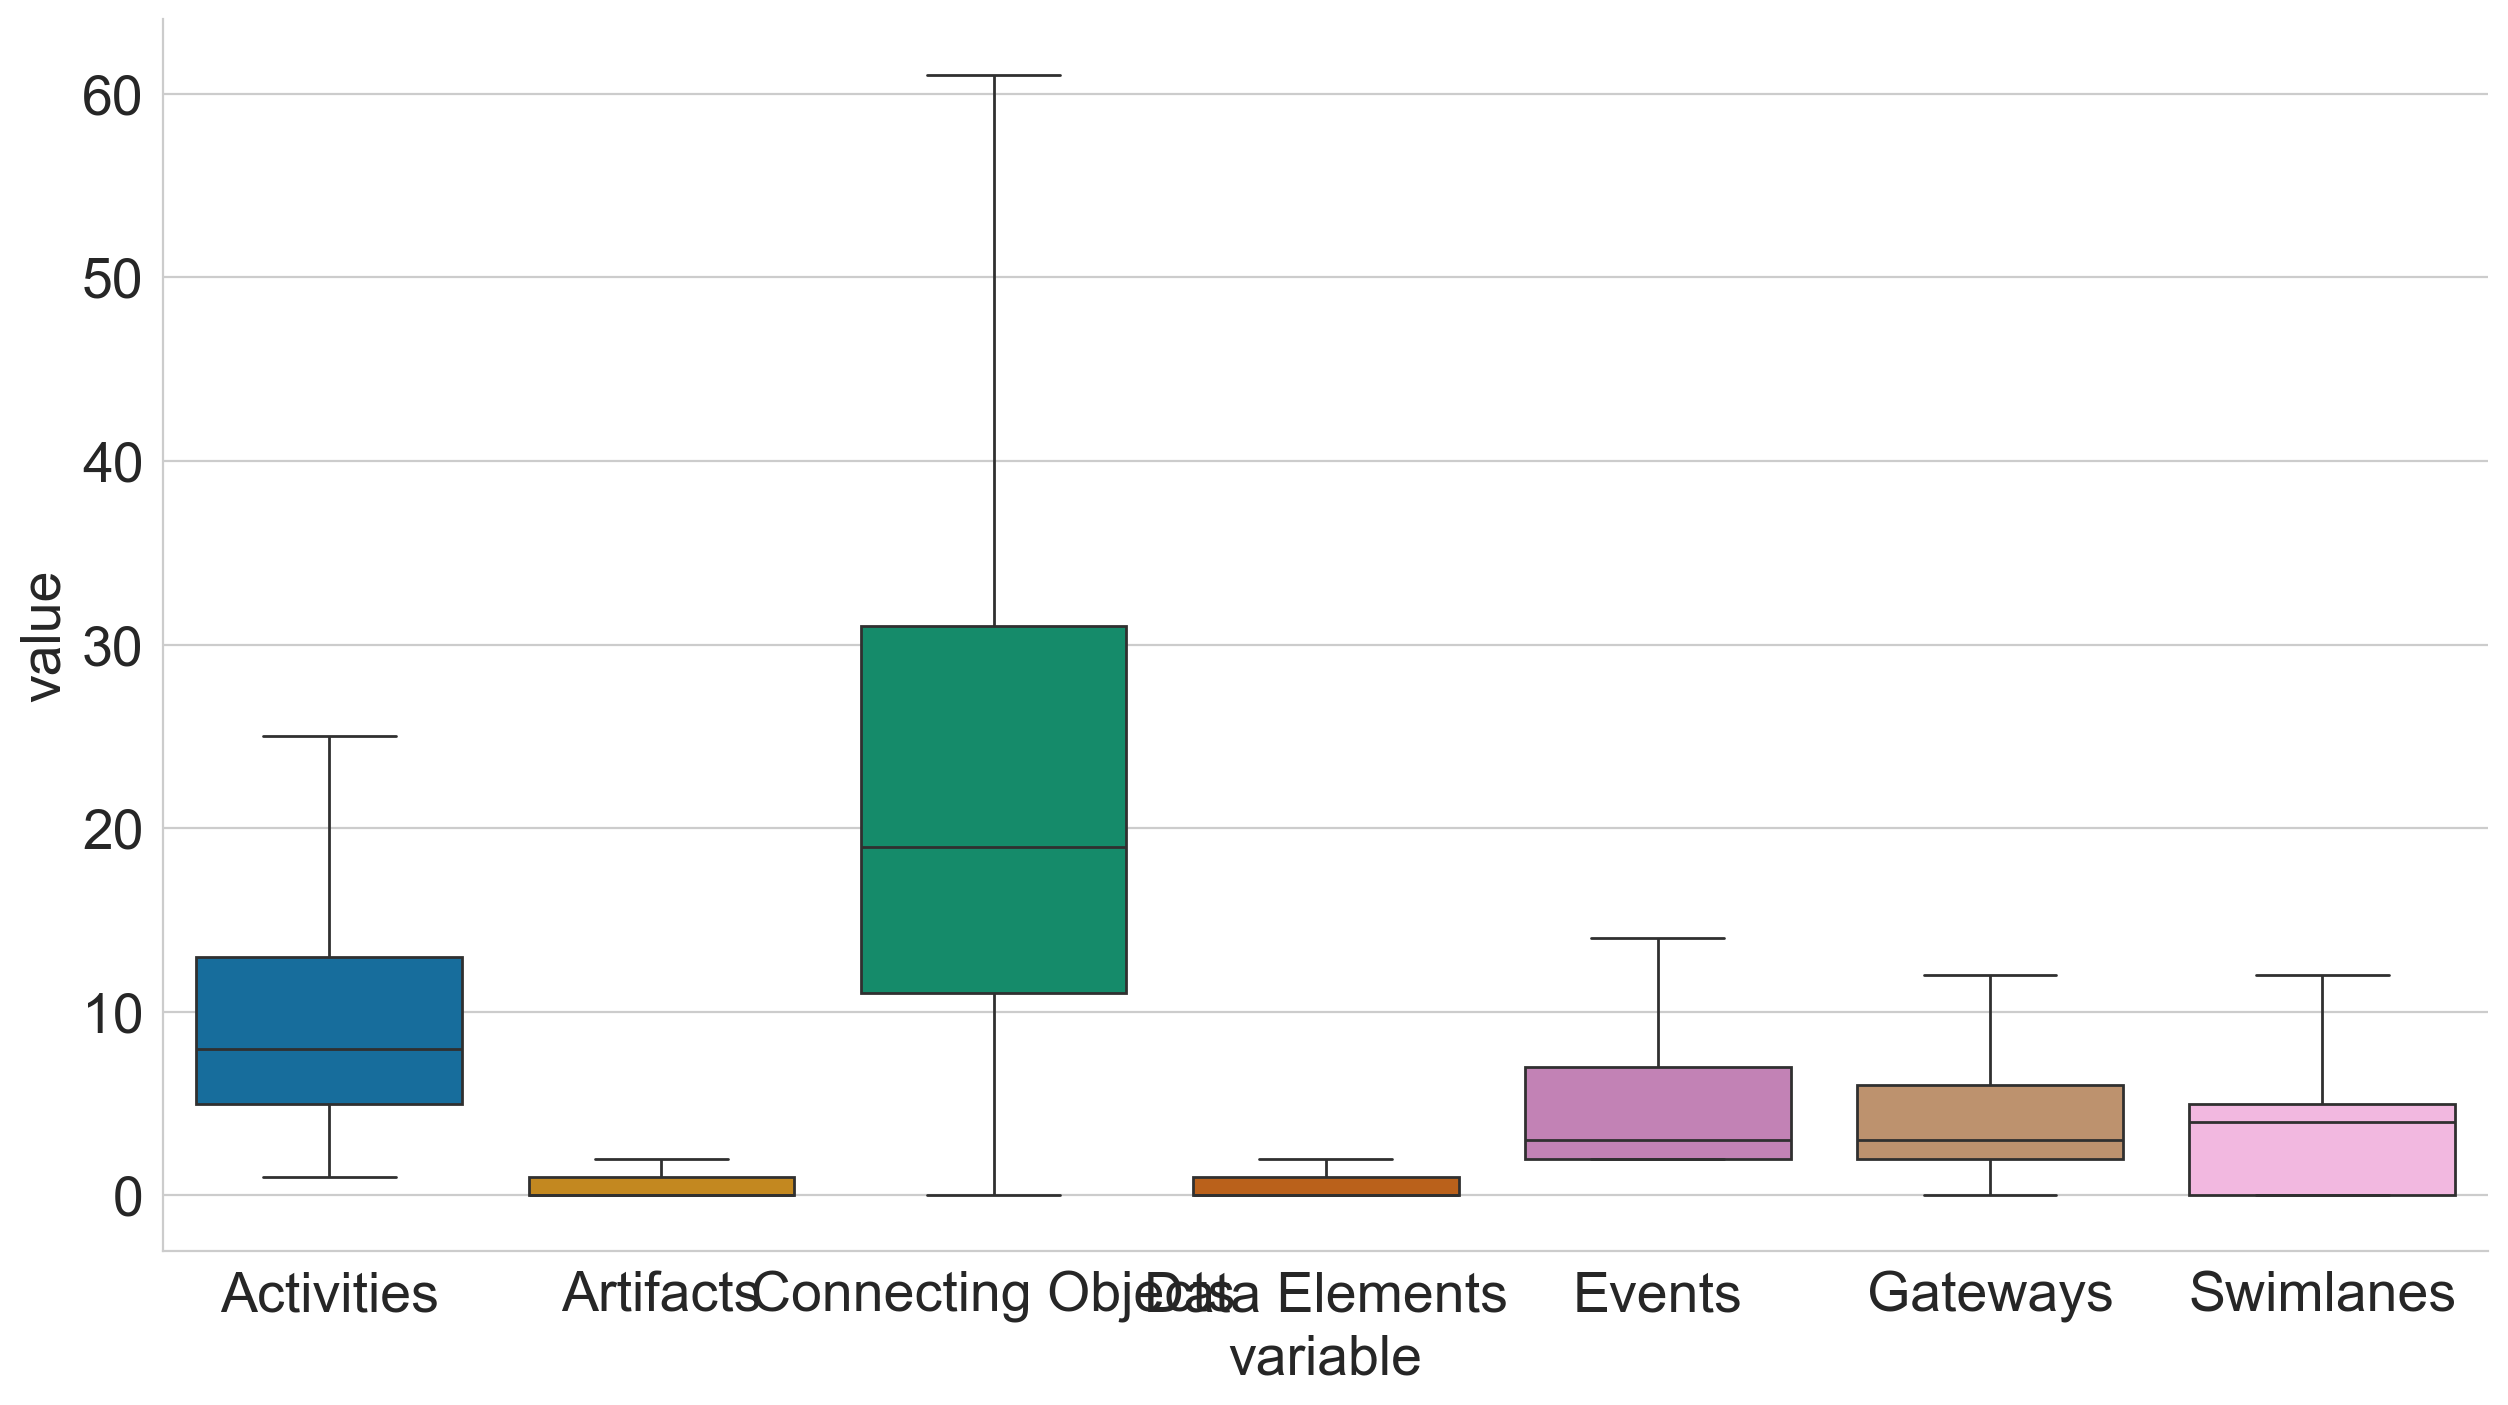

In [73]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", hue="variable", legend=False, data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind", n_colors=7))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [74]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%     max
No. of Edges  24721.0  25.763804  28.268782  0.0  11.0  19.0  31.0  1393.0
No. of Nodes  24721.0  26.828122  25.706095  3.0  12.0  21.0  33.0  1218.0

In [75]:
df_high_level.head()

No. of Edges  No. of Nodes
0             9            11
1            70            59
2            10             9
3            25            28
4            32            49

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

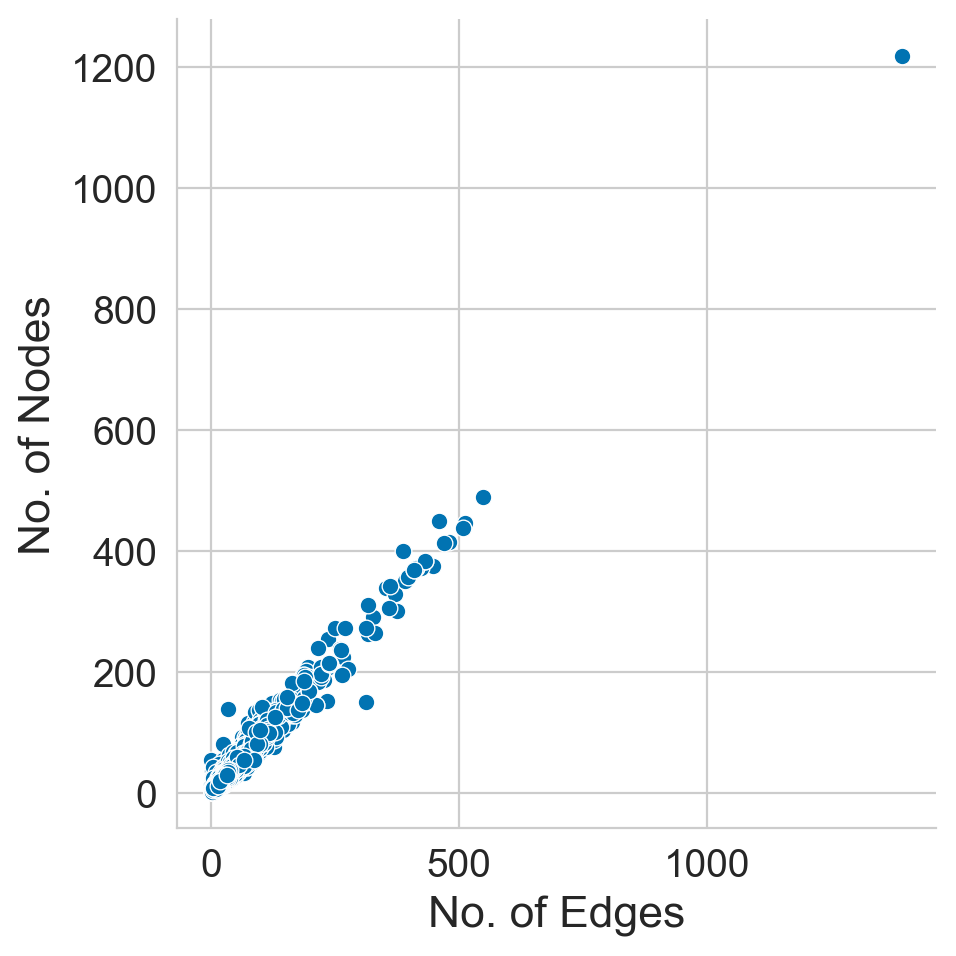

In [76]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [77]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [78]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0       12345678         2217
1    New Process         1183
2  Neuer Prozess          407
3  12345678_rev1          241
4  12345678_rev2          147
5       Jane Doe          128
6    New Diagram          103
7  12345678_rev3          103
8  12345678_rev4           80
9           BPMN           77

The number of distinct process names:

In [79]:
len(cnts_names)

37335

We use Signavio's color palette for the word cloud.

In [80]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

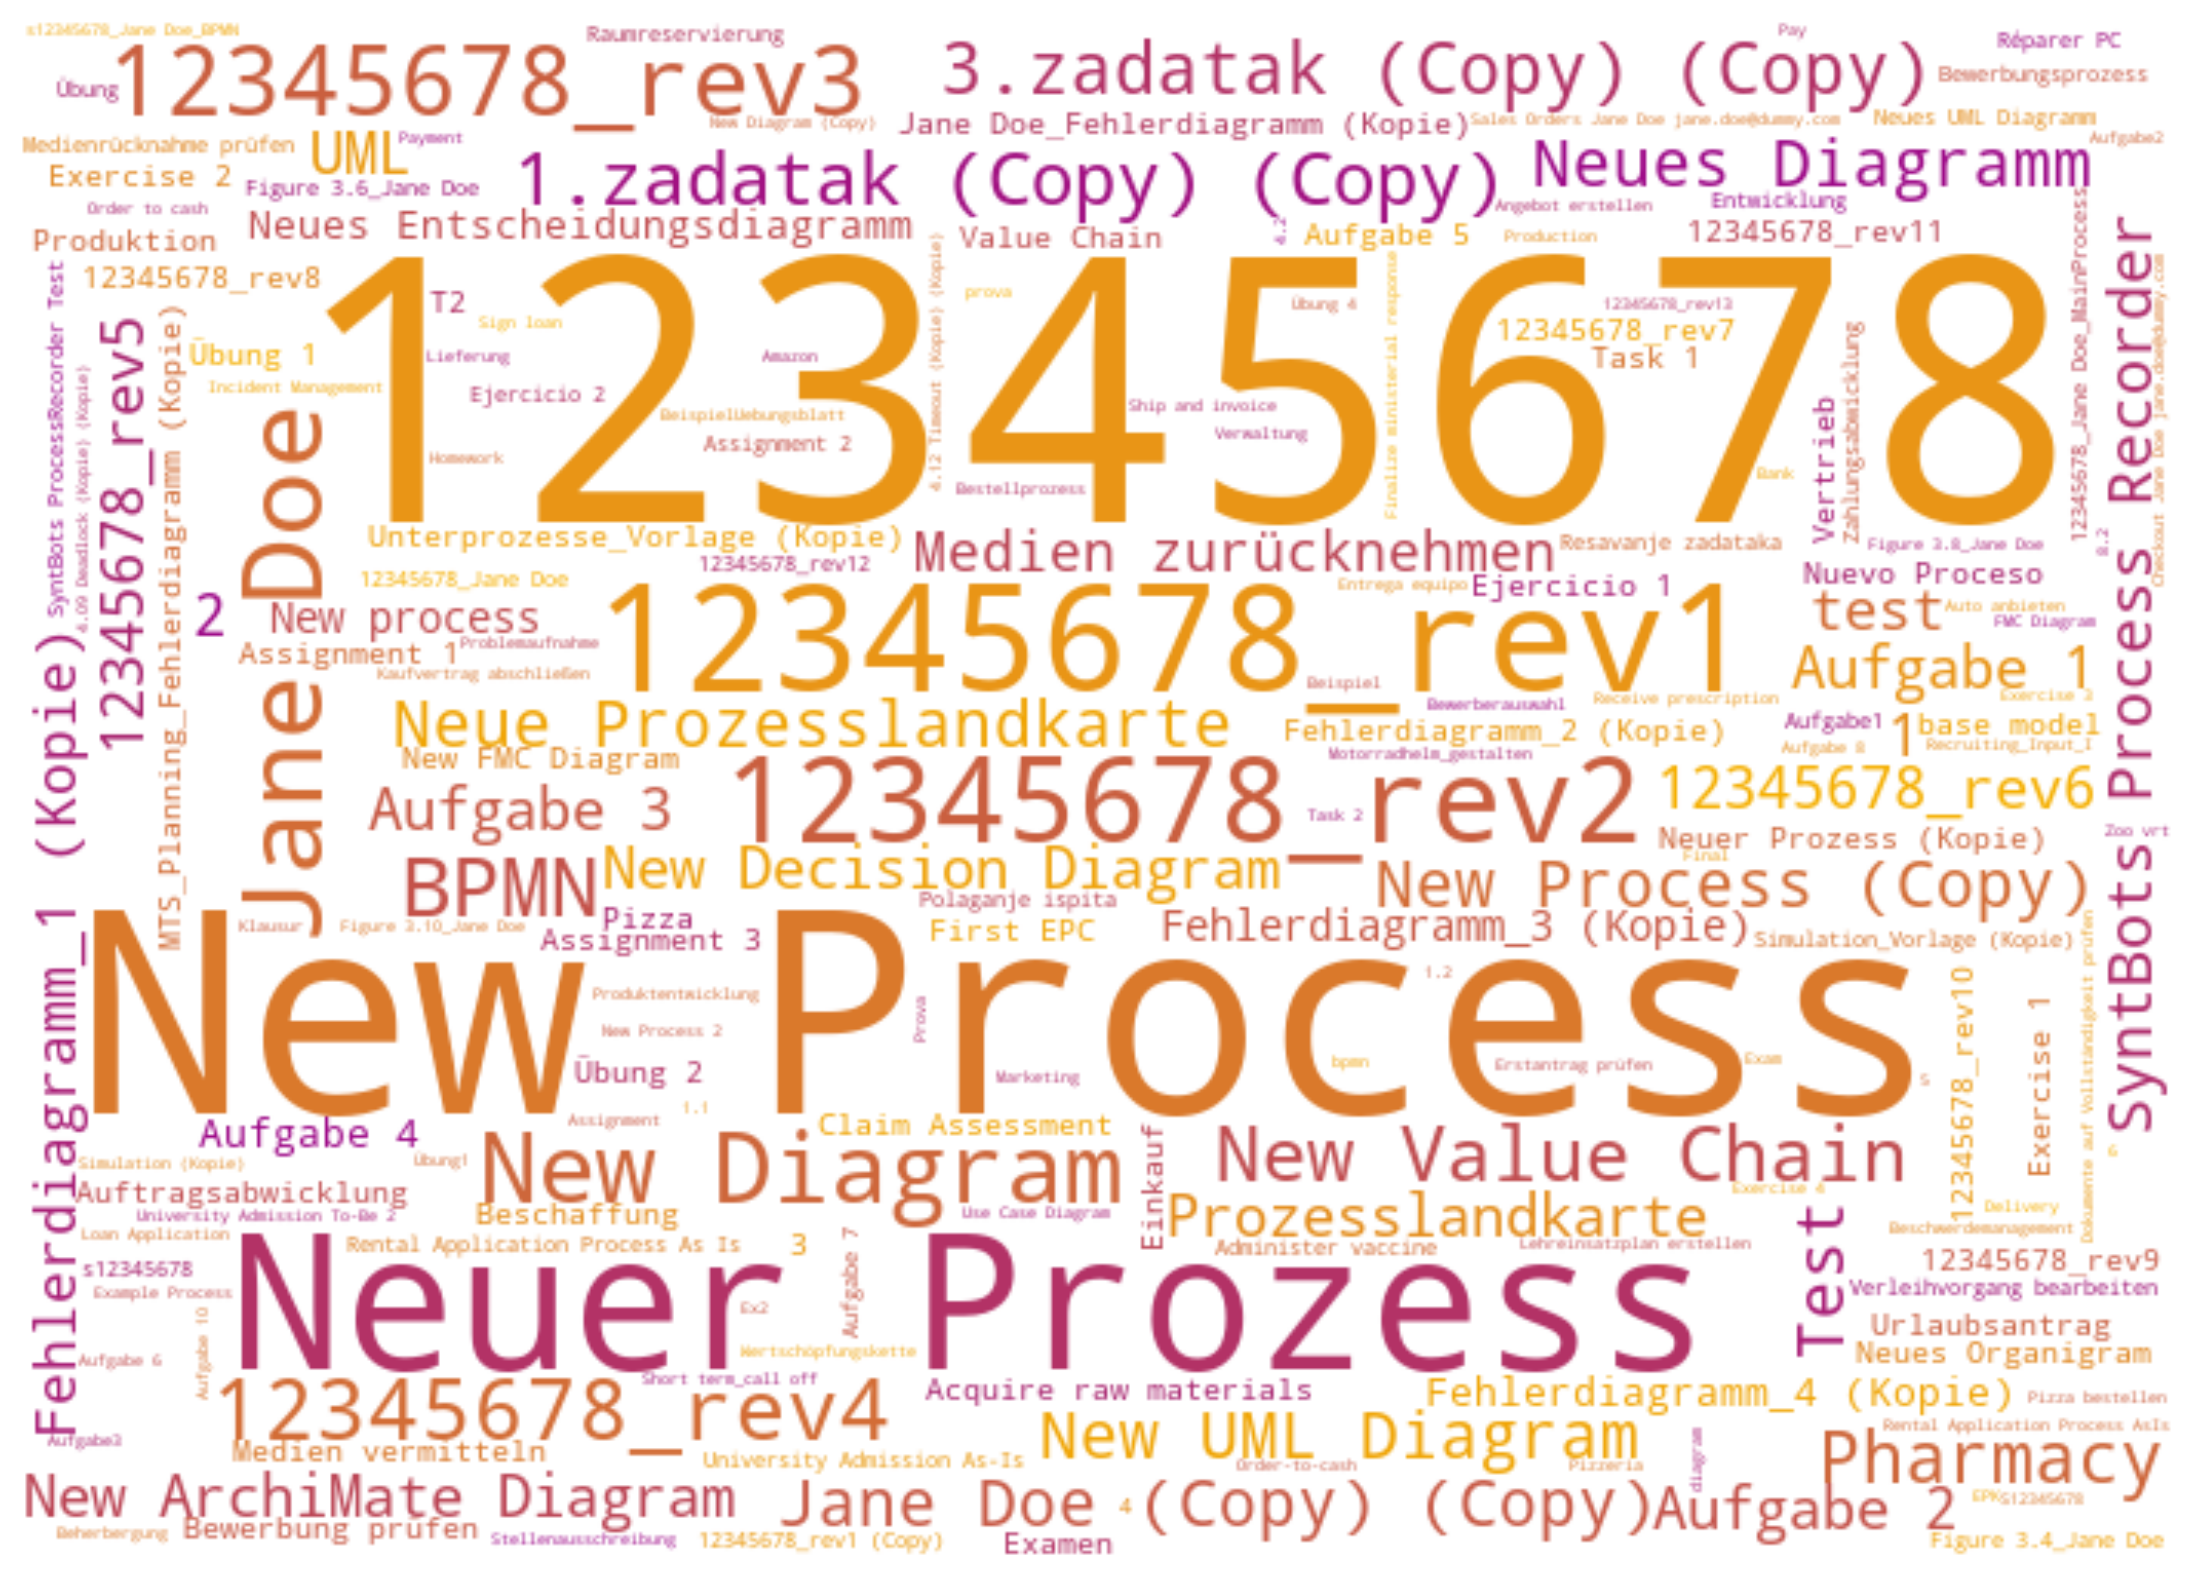

In [81]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [82]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No         8074
1       Yes         6742
2        Ja         3181
3      Nein         2929
4        no         2911
5      nein         2367
6        ja         2355
7       yes         2305
8        NO         1531
9  Customer         1291

The number of distinct element labels:

In [83]:
len(cnts_labels)

330996

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [84]:
len(df_bpmn)

1300125

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [85]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.45794524040515083

... while 64.9 % of the labels are used for only one element.

In [86]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.8108285296499051

In [87]:
len(cnts_labels[cnts_labels.occurrences==1])

268381

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [88]:
bins = cnts_labels
bins.head()

label  occurrences
0    No         8074
1   Yes         6742
2    Ja         3181
3  Nein         2929
4    no         2911

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [89]:
N = 10000
bins = bins.groupby(bins.index // N).sum(numeric_only=True)

In [90]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0       206351           10000
1        37422           20000
2        26638           30000
3        20000           40000
4        20000           50000

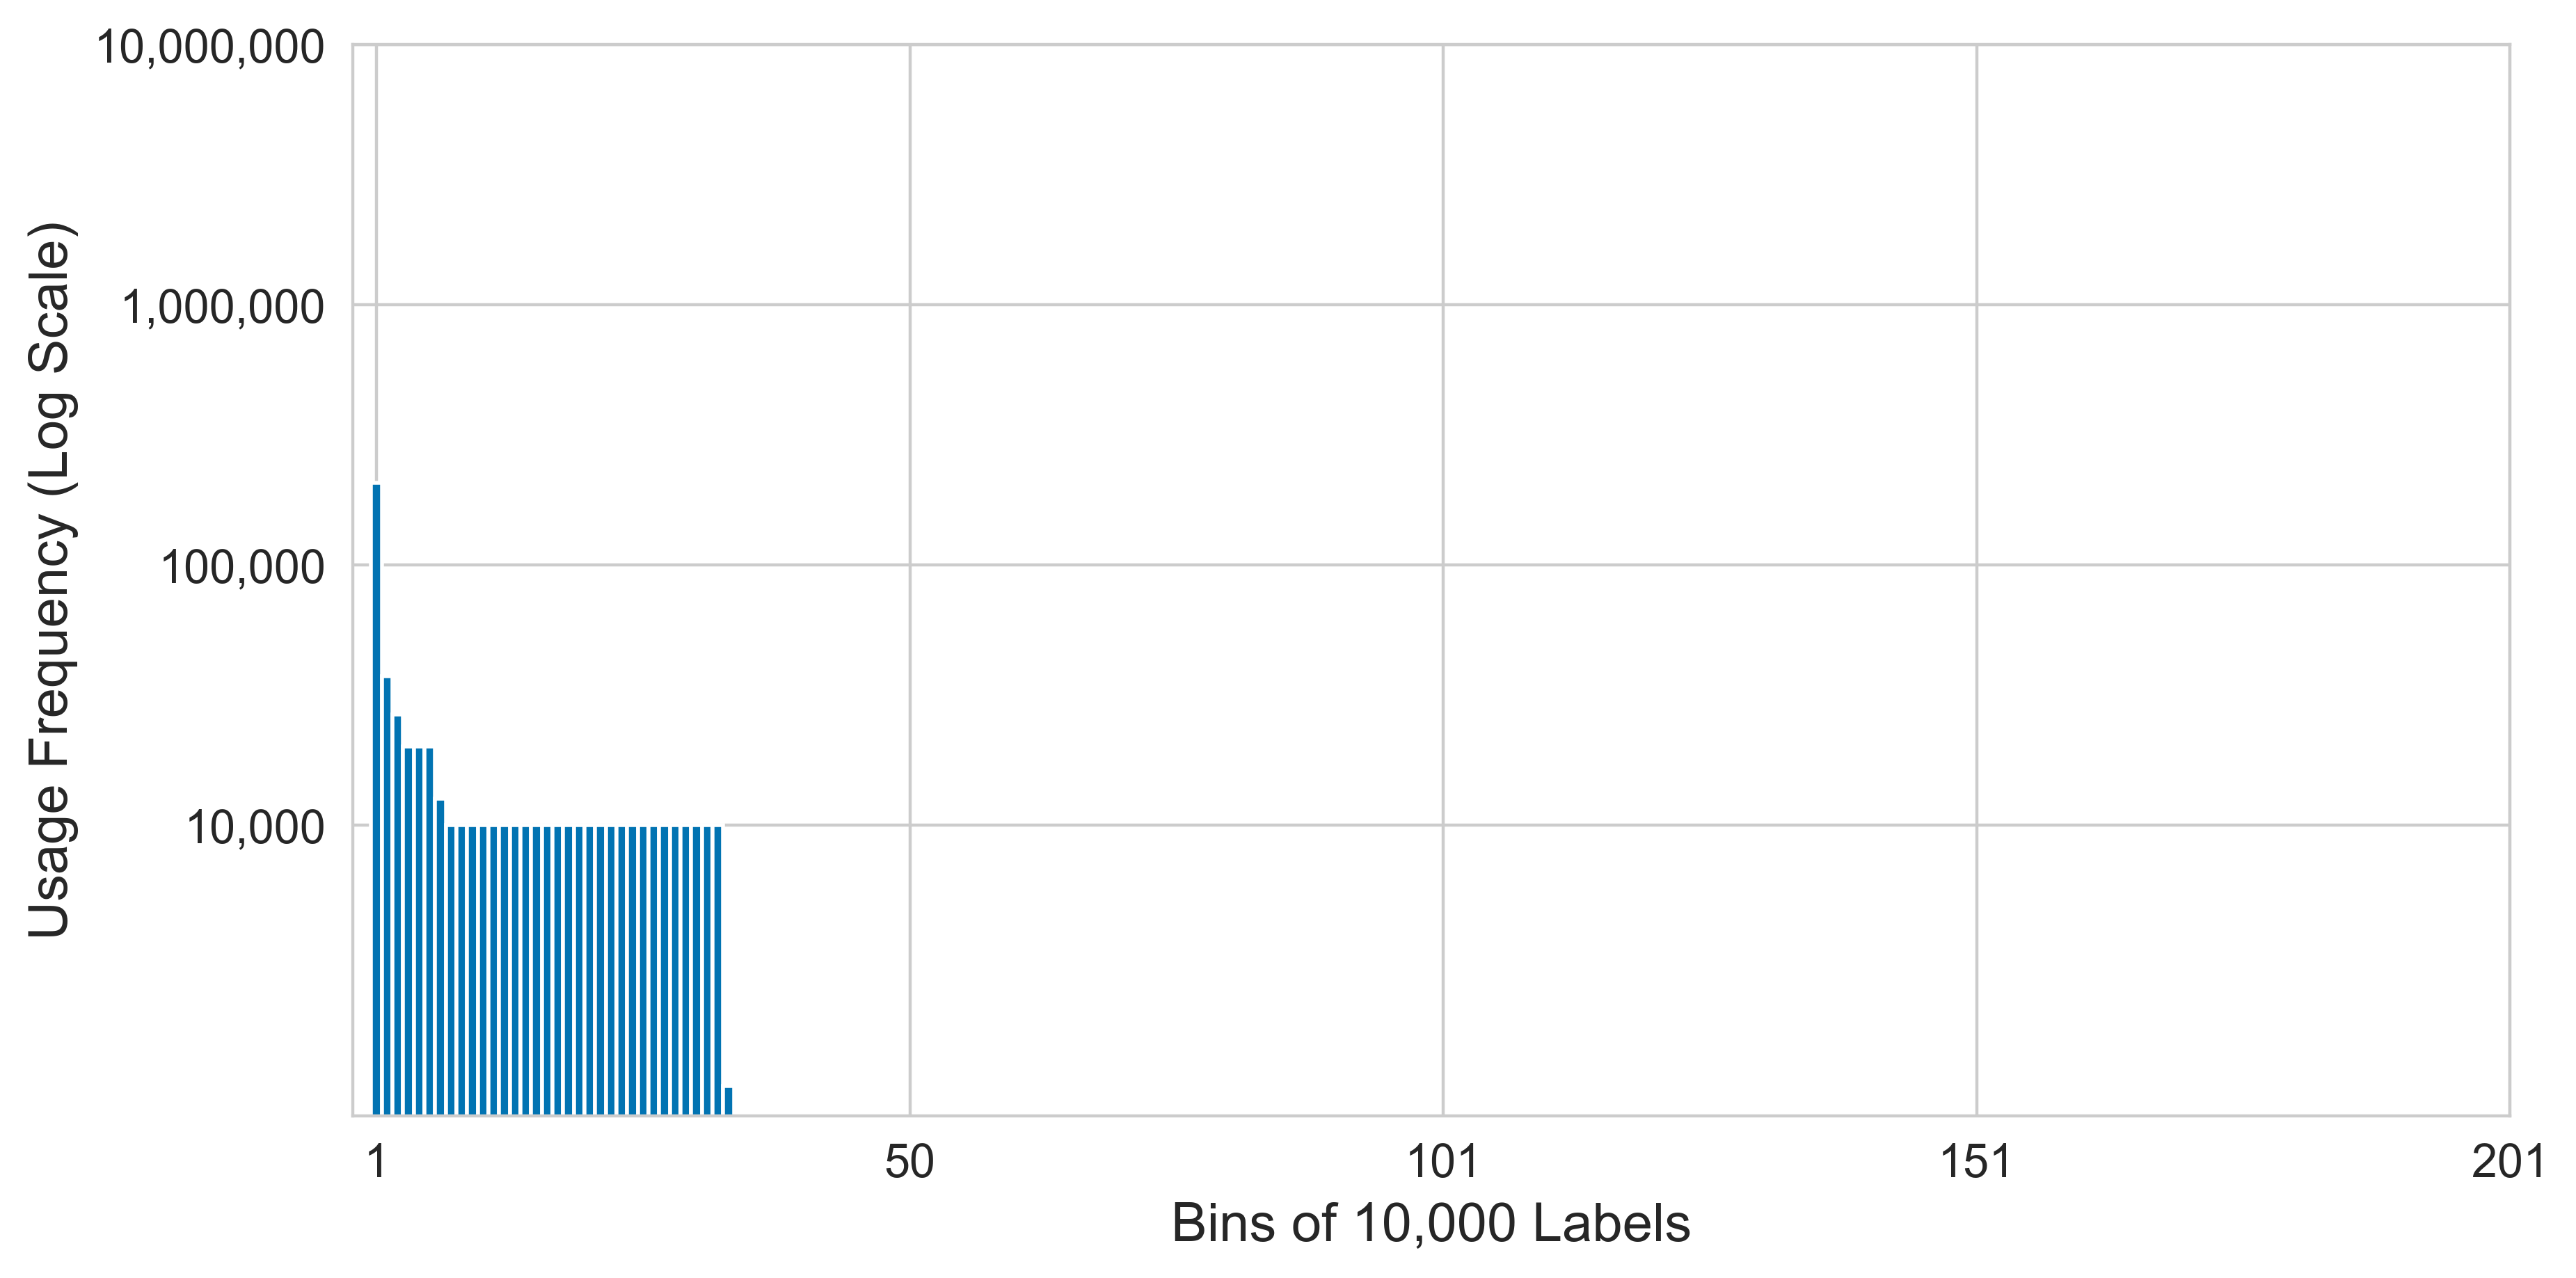

In [91]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

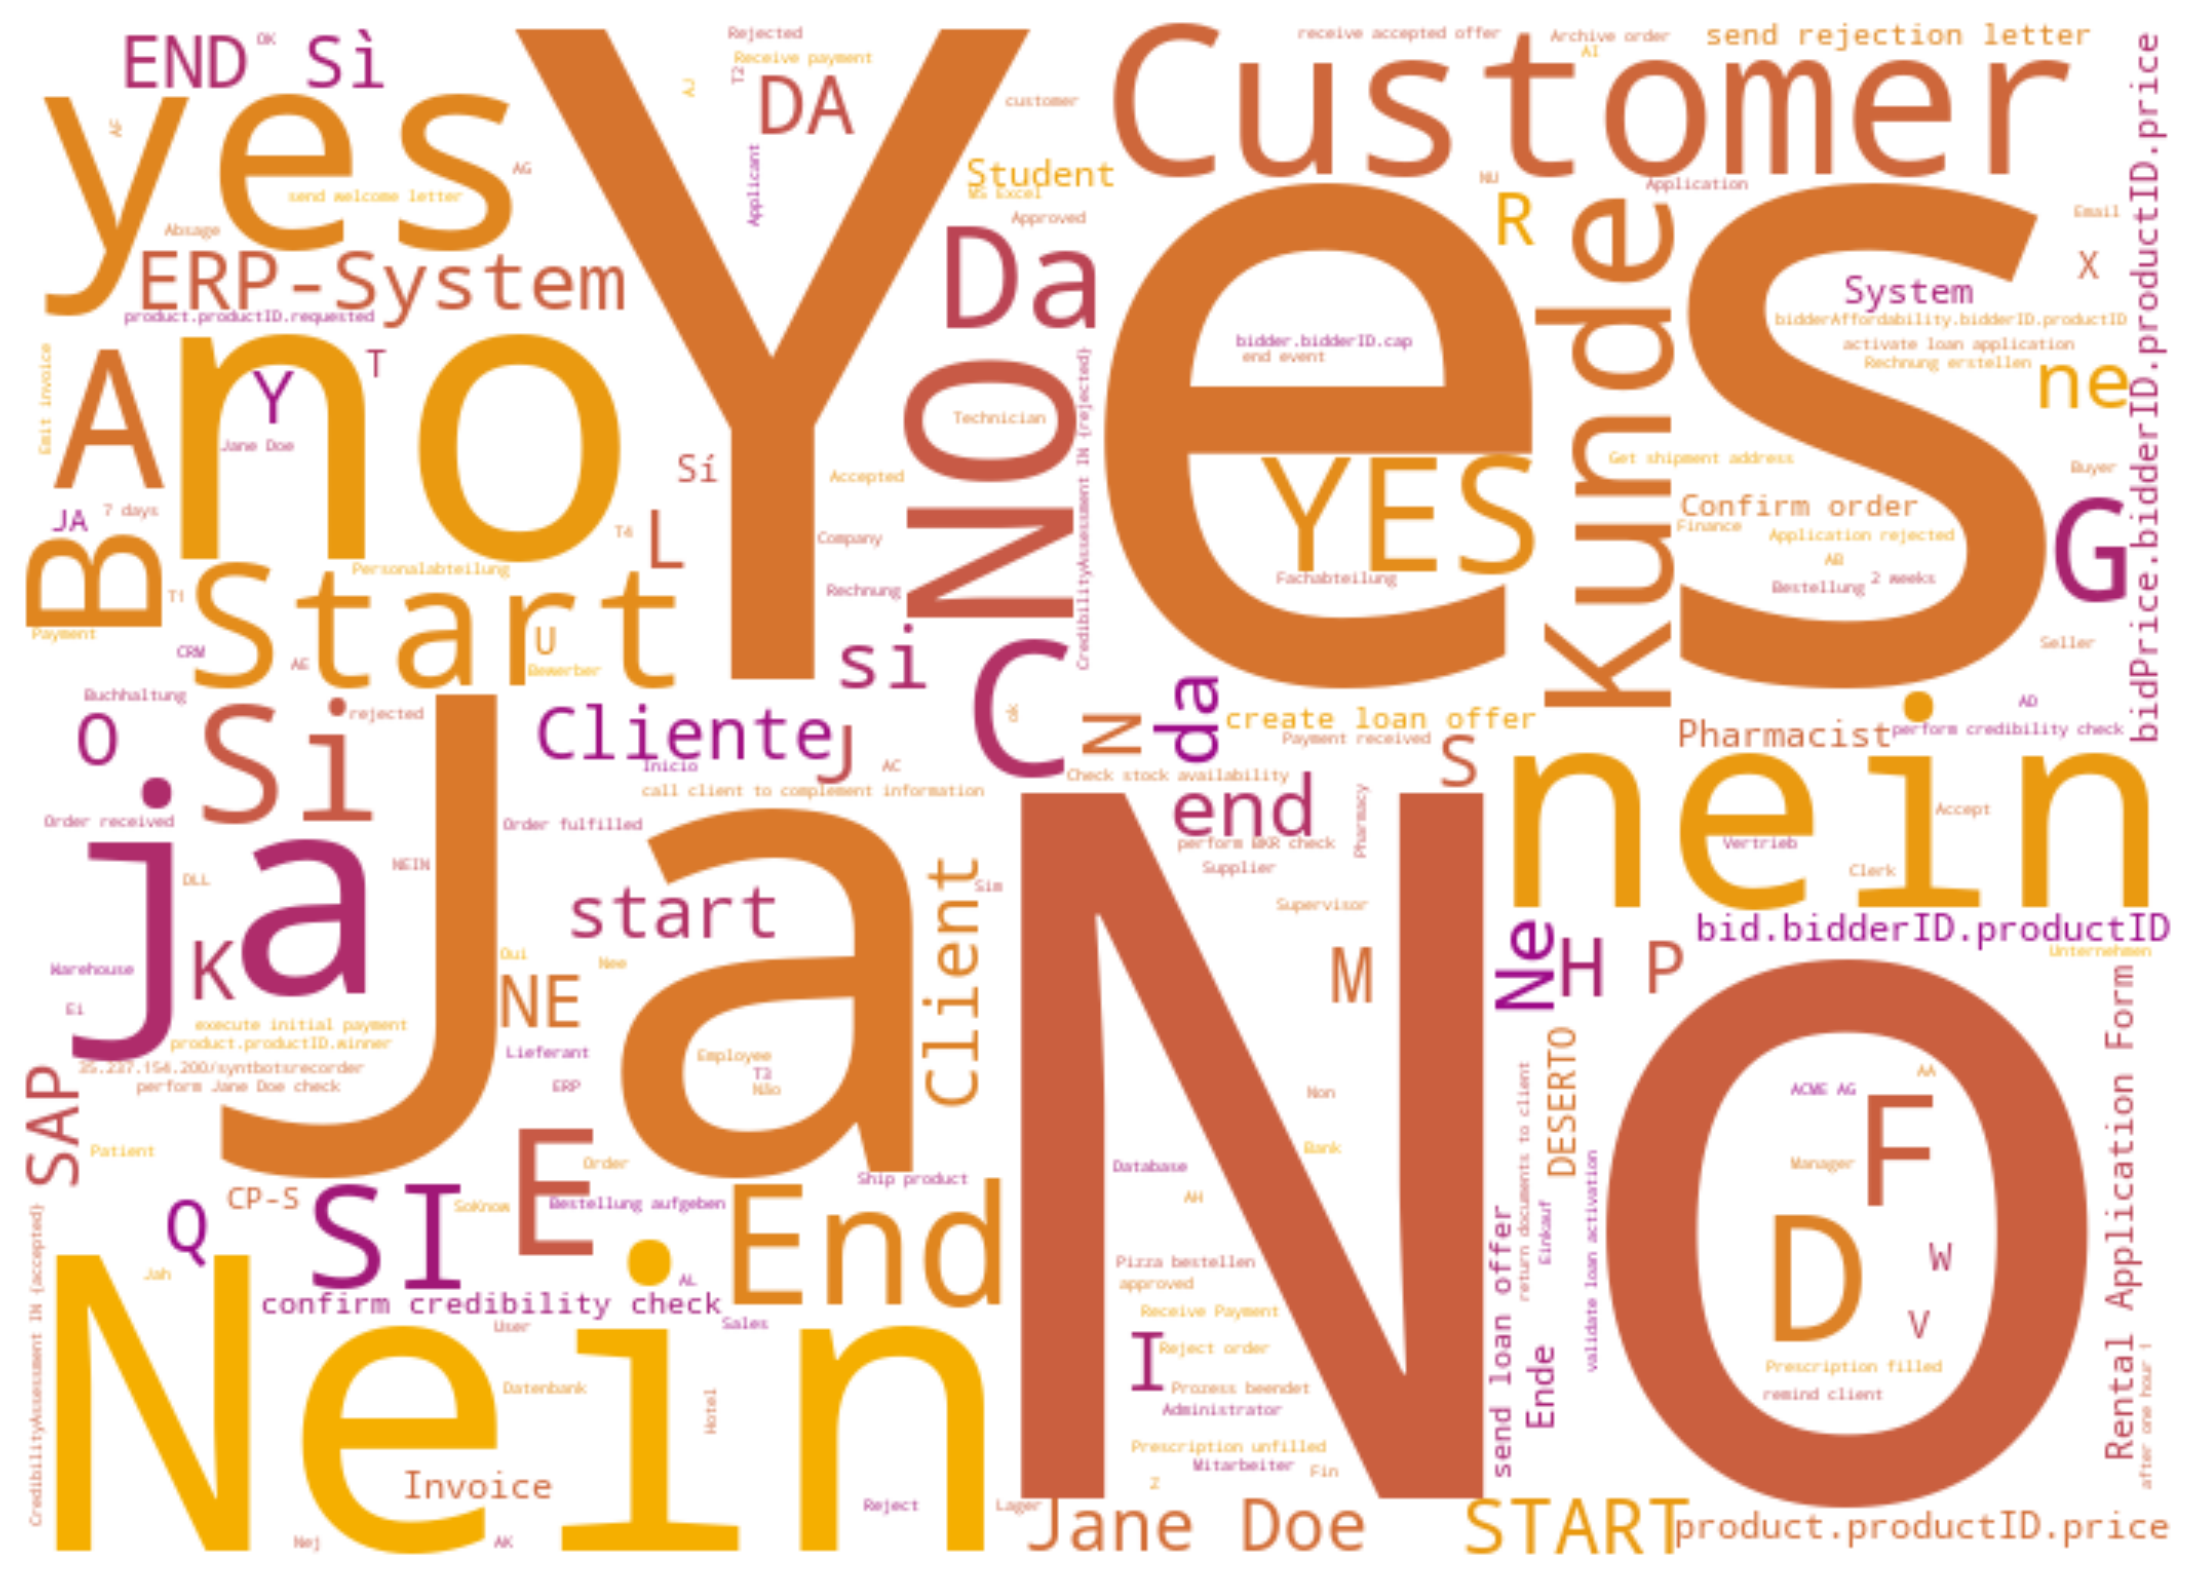

In [92]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()